<a href="https://colab.research.google.com/github/bhaweshiitk/6.869_project/blob/main/Clean_quantile_model_6_869_project_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
use_gdrive = False

In [ ]:
import os
from tqdm import tqdm

In [ ]:
! mkdir ~/.kaggle
! cd ~/.kaggle

# First download Kaggle.json from kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kmader/rsna-bone-age

100% 9.28G/9.29G [01:49<00:00, 86.6MB/s]
100% 9.29G/9.29G [01:49<00:00, 90.7MB/s]


In [ ]:
!mkdir /content/data
!unzip /content/rsna-bone-age.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4264.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4265.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4266.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4268.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4269.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4270.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4271.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4272.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4273.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-dataset/4275.png  
  inflating: /content/data/boneage-training-dataset/boneage-training-

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
!pip install tqdm
!pip install pytorch-forecasting
from tqdm.notebook import tqdm
import os
import copy
import pandas as pd
import PIL 
  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")
    print("You may want to try to use the GPU in Google Colab by clicking in:")
    print("Runtime > Change Runtime type > Hardware accelerator > GPU.")

     |████████████████████████████████| 127 kB 13.2 MB/s 
     |████████████████████████████████| 584 kB 69.8 MB/s 
     |████████████████████████████████| 308 kB 73.0 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 210 kB 43.2 MB/s 
     |████████████████████████████████| 596 kB 43.3 MB/s 
     |████████████████████████████████| 136 kB 79.9 MB/s 
     |████████████████████████████████| 409 kB 71.6 MB/s 
     |████████████████████████████████| 1.1 MB 68.7 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 144 kB 50.1 MB/s 
     |████████████████████████████████| 271 kB 78.0 MB/s 
     |████████████████████████████████| 78 kB 9.4 MB/s 
     |████████████████████████████████| 49 kB 8.4 MB/s 
     |████████████████████████████████| 112 kB 76.8 MB/s 
     |████████████████████████████████| 146 kB 80.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=1

In [ ]:
class ImageModel(torch.nn.Module):

  def __init__(self, pretrained=True):
    super(ImageModel, self).__init__()
    model_ft = models.resnet18(pretrained=pretrained)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Linear(512, 256), nn.Dropout(p=0.2), 
                             nn.ReLU(), nn.Linear(256, 64), nn.Dropout(p=0.2), 
                             nn.Linear(64, 2))
    self.model = model_ft 
    
  def forward(self, x):
    return self.model(x)

In [ ]:
from torchvision.transforms.functional import to_grayscale

def get_image_transforms():
  
    transform = transforms.Compose([
            transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomRotation(degrees=(-10, 10), expand=False),
            transforms.RandomAffine(degrees=(-10, 10), scale=(0.8,1.2)), 
	          transforms.RandomHorizontalFlip(p=0.15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.1871, 0.1871, 0.1871],std=[0.1401, 0.1401, 0.1401])
        ])
    return transform

from PIL import Image

class ImageDataset(torch.utils.data.Dataset):

  def __init__(self, df, image_dir):
    self.image_paths = []
    self.bone_ages = []
    for image_id, boneage in zip(df['id'].values, df['boneage'].values):
      self.image_paths.append(f"{image_dir}/{image_id}.png")
      self.bone_ages.append(boneage)
    
    self.transform = get_image_transforms()
  
  def __len__(self):
    return len(self.image_paths)
  
  def __getitem__(self, idx):
    filepath = self.image_paths[idx]
    boneage = self.bone_ages[idx]

    image = Image.open(filepath)
    image = self.transform(image)

    return {'image': image, 'age': boneage}

In [ ]:
class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
            losses.append(
                torch.max(
                   (q-1) * errors, 
                   q * errors
            ).unsqueeze(1))
        loss = torch.mean(
            torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss

In [ ]:
def make_optimizer(model, learning_rate, print_parameters=False):
    # Get all the parameters
    params_to_update = list(model.parameters())
    if print_parameters:
      print("Params to learn:")
      for name, param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)

 
    optimizer = optim.SGD(params_to_update, lr=learning_rate, momentum = 0.9)
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = QuantileLoss
    return criterion

In [ ]:

def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False,
                num_epochs=25, quantile = (0.1, 0.9)):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for batch in tqdm(dataloaders[phase]):
                image = batch['image'].to(device)
                age = batch['age'].to(device)
                # inputs = inputs.to(device)
                # labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(image)
                    loss = criterion(quantile)(outputs.squeeze(), age.to(torch.float32))
                    print(loss)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * image.size(0)
                # running_corrects += torch.sum(preds == age.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'train':
                train_acc_history.append(epoch_loss)
            if phase == 'val':
                val_acc_history.append(epoch_loss)
            if save_all_epochs:
                torch.save(model.state_dict(), os.path.join(save_dir, f'weights_{epoch}.pt'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, 'weights_best_val_acc.pt'))
    torch.save(model.state_dict(), os.path.join(save_dir, 'weights_last.pt'.format(epoch)))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [ ]:
from pathlib import Path
data_dir = "./data"
models_dir = data_dir + '/models'
Path(models_dir).mkdir(parents=True, exist_ok=True)
save_dir = models_dir + '/trained_model_1'
os.makedirs(save_dir, exist_ok=True)

In [ ]:
batch_size = 32

shuffle_datasets = True

num_epochs = 60 

learning_rate = 0.01 

### IO
# Path to a model file to use to start weights at
resume_from = None

# Save all epochs so that you can select the model from a particular epoch
save_all_epochs = False

# Whether to use early stopping (load the model with best accuracy), or not
early_stopping = True

# Dataset directory
image_dir = "/content/data/boneage-training-dataset/boneage-training-dataset"
dataframe_path = "/content/data/boneage-training-dataset.csv"

# Image size
image_size = (224, 224)

# Directory to save weights to
save_dir = models_dir + '/trained_model_1'
os.makedirs(save_dir, exist_ok=True)


In [ ]:
import pandas as pd
df = pd.read_csv(dataframe_path)

In [ ]:
import pickle
# with open('ids_train.pkl', 'wb') as f:
#   pickle.dump([ids_train, ids_test, ids_val], f)
with open('ids_train.pkl', 'rb') as f:
  id_list = pickle.load(f)
train_df = df[df.id.isin(id_list[0])]
test_df = df[df.id.isin(id_list[1])]
val_df = df[df.id.isin(id_list[2])]

In [ ]:
train_dataset = ImageDataset(train_df, image_dir)
val_dataset = ImageDataset(val_df, image_dir)
test_dataset = ImageDataset(test_df, image_dir)
len(train_dataset), len(test_dataset), len(val_dataset)

(6000, 5611, 1000)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*15, shuffle=False, num_workers = 2)
dataloader = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

In [ ]:
model = ImageModel(pretrained=False)
model.to(device)

ImageModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
alpha = 0.4
quantile = (alpha/2, 1-alpha/2)

In [ ]:
criterion = get_loss()

optimizer_1 = make_optimizer(model, learning_rate=learning_rate)

trained_model_1, validation_history_1, train_history_1 = train_model(model=model, 
                                                                     dataloaders=dataloader, 
                                                                     criterion=criterion, 
                                                                     optimizer=optimizer_1,
                                                                     save_dir=save_dir, 
                                                                     save_all_epochs=save_all_epochs, 
                                                                     num_epochs=num_epochs,
                                                                     quantile = quantile)
del optimizer_1, trained_model_1

Epoch 1/60
----------


  0%|          | 0/188 [00:00<?, ?it/s]

tensor(119.6147, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(129.7273, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(125.6164, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(130.4023, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(128.2814, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(110.4429, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(126.0344, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(95.7402, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(61.9522, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(14.3382, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(19.0224, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(32.1072, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(47.8671, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(56.2837, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(58.3070, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(50.7662, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(38.7149, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(10.1767, device='cuda:0')
tensor(11.4366, device='cuda:0')
tensor(9.2457, device='cuda:0')
tensor(9.9332, device='cuda:0')
tensor(8.1846, device='cuda:0')
tensor(8.7862, device='cuda:0')
tensor(7.2734, device='cuda:0')
tensor(8.0516, device='cuda:0')
tensor(9.9776, device='cuda:0')
tensor(8.4143, device='cuda:0')
tensor(7.7409, device='cuda:0')
tensor(8.1070, device='cuda:0')
tensor(8.1936, device='cuda:0')
tensor(8.1372, device='cuda:0')
tensor(7.9365, device='cuda:0')
tensor(7.3725, device='cuda:0')
tensor(7.6095, device='cuda:0')
tensor(6.9230, device='cuda:0')
tensor(7.5110, device='cuda:0')
tensor(7.7807, device='cuda:0')
tensor(8.0829, device='cuda:0')
tensor(6.9062, device='cuda:0')
tensor(7.8178, device='cuda:0')
tensor(7.4211, device='cuda:0')
tensor(7.1246, device='cuda:0')
tensor(7.0904, device='cuda:0')
tensor(8.6062, device='cuda:0')
tensor(8.3403, device='cuda:0')
tensor(6.9379, device='cuda:0')
tensor(8.3642, device='cuda:0')
tensor(7.0784, device='cuda:0')
tensor

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(7.4850, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.4486, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5007, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4690, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0185, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.3715, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.2031, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.4516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.9982, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.6292, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.6512, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4644, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.8232, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.6122, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.7275, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.1249, device='cuda:0'

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(9.8661, device='cuda:0')
tensor(11.6649, device='cuda:0')
tensor(10.8827, device='cuda:0')
tensor(11.0041, device='cuda:0')
tensor(10.6723, device='cuda:0')
tensor(10.6974, device='cuda:0')
tensor(10.3121, device='cuda:0')
tensor(10.4443, device='cuda:0')
tensor(10.9975, device='cuda:0')
tensor(10.2883, device='cuda:0')
tensor(10.1673, device='cuda:0')
tensor(10.1012, device='cuda:0')
tensor(10.3627, device='cuda:0')
tensor(10.4488, device='cuda:0')
tensor(10.6564, device='cuda:0')
tensor(10.1234, device='cuda:0')
tensor(10.2388, device='cuda:0')
tensor(10.1468, device='cuda:0')
tensor(10.1630, device='cuda:0')
tensor(10.3175, device='cuda:0')
tensor(10.2141, device='cuda:0')
tensor(10.2535, device='cuda:0')
tensor(10.5054, device='cuda:0')
tensor(10.2740, device='cuda:0')
tensor(10.0586, device='cuda:0')
tensor(10.1967, device='cuda:0')
tensor(10.3952, device='cuda:0')
tensor(10.1080, device='cuda:0')
tensor(10.0449, device='cuda:0')
tensor(10.5181, device='cuda:0')
tensor(10.3

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(9.6666, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.7077, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(12.1297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.7268, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.1645, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.0156, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.4697, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4712, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.4913, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.3677, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.4273, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2350, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.9210, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(12.0402, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.9449, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.6708, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3315, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.9133, device

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(17.4776, device='cuda:0')
tensor(19.0400, device='cuda:0')
tensor(7.2198, device='cuda:0')
tensor(9.1658, device='cuda:0')
tensor(11.8415, device='cuda:0')
tensor(11.0804, device='cuda:0')
tensor(8.1077, device='cuda:0')
tensor(12.1164, device='cuda:0')
tensor(14.4413, device='cuda:0')
tensor(9.0810, device='cuda:0')
tensor(8.5400, device='cuda:0')
tensor(8.6320, device='cuda:0')
tensor(10.6604, device='cuda:0')
tensor(10.2006, device='cuda:0')
tensor(10.7705, device='cuda:0')
tensor(9.9378, device='cuda:0')
tensor(11.1938, device='cuda:0')
tensor(8.4792, device='cuda:0')
tensor(8.3305, device='cuda:0')
tensor(11.5979, device='cuda:0')
tensor(7.8212, device='cuda:0')
tensor(8.0075, device='cuda:0')
tensor(9.7259, device='cuda:0')
tensor(7.8703, device='cuda:0')
tensor(7.7173, device='cuda:0')
tensor(8.7701, device='cuda:0')
tensor(10.9022, device='cuda:0')
tensor(9.6188, device='cuda:0')
tensor(9.1383, device='cuda:0')
tensor(9.7871, device='cuda:0')
tensor(7.4982, device='cuda:

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(9.5832, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.1913, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(16.8039, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.2095, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3772, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0870, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.2837, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.8641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.0209, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.1260, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.1431, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.6315, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.4910, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.1278, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.0949, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.6888, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.5282, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.7955, device

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(12.5205, device='cuda:0')
tensor(12.6303, device='cuda:0')
tensor(8.3995, device='cuda:0')
tensor(10.0915, device='cuda:0')
tensor(9.1321, device='cuda:0')
tensor(9.6511, device='cuda:0')
tensor(8.0878, device='cuda:0')
tensor(9.7197, device='cuda:0')
tensor(10.5035, device='cuda:0')
tensor(8.4836, device='cuda:0')
tensor(7.8990, device='cuda:0')
tensor(8.3351, device='cuda:0')
tensor(9.3858, device='cuda:0')
tensor(9.0631, device='cuda:0')
tensor(8.6812, device='cuda:0')
tensor(8.7916, device='cuda:0')
tensor(8.9885, device='cuda:0')
tensor(7.9409, device='cuda:0')
tensor(8.2916, device='cuda:0')
tensor(8.5054, device='cuda:0')
tensor(8.4522, device='cuda:0')
tensor(8.2895, device='cuda:0')
tensor(8.7410, device='cuda:0')
tensor(8.2522, device='cuda:0')
tensor(7.9325, device='cuda:0')
tensor(8.6597, device='cuda:0')
tensor(9.6912, device='cuda:0')
tensor(8.8030, device='cuda:0')
tensor(8.4073, device='cuda:0')
tensor(8.9974, device='cuda:0')
tensor(8.2057, device='cuda:0')
tens

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(8.1217, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9885, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3494, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5788, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.9425, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2842, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.3964, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.6096, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(12.0429, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2908, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5792, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6886, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7636, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.1466, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0752, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.3181, device='cuda:0'

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(13.8139, device='cuda:0')
tensor(14.9607, device='cuda:0')
tensor(7.2014, device='cuda:0')
tensor(8.8876, device='cuda:0')
tensor(9.7433, device='cuda:0')
tensor(10.7845, device='cuda:0')
tensor(6.6694, device='cuda:0')
tensor(8.2699, device='cuda:0')
tensor(11.0520, device='cuda:0')
tensor(7.6341, device='cuda:0')
tensor(6.4496, device='cuda:0')
tensor(7.0442, device='cuda:0')
tensor(8.1627, device='cuda:0')
tensor(8.1675, device='cuda:0')
tensor(7.8522, device='cuda:0')
tensor(7.6745, device='cuda:0')
tensor(8.4773, device='cuda:0')
tensor(6.4783, device='cuda:0')
tensor(6.9978, device='cuda:0')
tensor(7.8808, device='cuda:0')
tensor(6.6154, device='cuda:0')
tensor(6.4750, device='cuda:0')
tensor(7.4623, device='cuda:0')
tensor(6.4020, device='cuda:0')
tensor(6.4046, device='cuda:0')
tensor(6.7490, device='cuda:0')
tensor(8.2750, device='cuda:0')
tensor(8.1384, device='cuda:0')
tensor(7.1457, device='cuda:0')
tensor(9.2201, device='cuda:0')
tensor(6.3730, device='cuda:0')
tens

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(10.6896, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.8983, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.7322, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(12.0482, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0601, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5374, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4053, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2657, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3626, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4702, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3783, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.5623, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.7495, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.1226, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3998, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.3623, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.8306, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.4297, device='cuda:

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(9.8142, device='cuda:0')
tensor(10.3073, device='cuda:0')
tensor(9.4083, device='cuda:0')
tensor(10.2029, device='cuda:0')
tensor(8.1406, device='cuda:0')
tensor(8.8336, device='cuda:0')
tensor(7.6409, device='cuda:0')
tensor(8.2019, device='cuda:0')
tensor(8.8098, device='cuda:0')
tensor(7.8942, device='cuda:0')
tensor(7.4379, device='cuda:0')
tensor(8.3774, device='cuda:0')
tensor(8.1815, device='cuda:0')
tensor(8.2264, device='cuda:0')
tensor(8.4786, device='cuda:0')
tensor(7.8920, device='cuda:0')
tensor(7.6735, device='cuda:0')
tensor(7.6183, device='cuda:0')
tensor(7.8861, device='cuda:0')
tensor(7.7825, device='cuda:0')
tensor(7.9226, device='cuda:0')
tensor(7.8386, device='cuda:0')
tensor(8.3824, device='cuda:0')
tensor(7.8366, device='cuda:0')
tensor(7.6702, device='cuda:0')
tensor(7.7209, device='cuda:0')
tensor(8.2494, device='cuda:0')
tensor(8.4526, device='cuda:0')
tensor(7.7211, device='cuda:0')
tensor(8.4297, device='cuda:0')
tensor(7.6088, device='cuda:0')
tensor

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(10.0239, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.7507, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.6823, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.9410, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.7986, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.7233, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.7114, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.5600, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.1495, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.8755, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.9852, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.8730, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.7936, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.1506, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8384, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8928, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.3309, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.8986, device='cuda:0

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(13.0577, device='cuda:0')
tensor(16.8659, device='cuda:0')
tensor(8.5643, device='cuda:0')
tensor(10.6849, device='cuda:0')
tensor(11.5292, device='cuda:0')
tensor(13.1370, device='cuda:0')
tensor(8.5938, device='cuda:0')
tensor(12.8577, device='cuda:0')
tensor(14.5624, device='cuda:0')
tensor(7.6966, device='cuda:0')
tensor(9.8241, device='cuda:0')
tensor(9.7379, device='cuda:0')
tensor(11.1339, device='cuda:0')
tensor(10.8400, device='cuda:0')
tensor(11.2890, device='cuda:0')
tensor(10.6441, device='cuda:0')
tensor(13.1999, device='cuda:0')
tensor(9.1909, device='cuda:0')
tensor(9.1695, device='cuda:0')
tensor(11.2103, device='cuda:0')
tensor(9.3144, device='cuda:0')
tensor(7.8870, device='cuda:0')
tensor(9.0828, device='cuda:0')
tensor(9.3024, device='cuda:0')
tensor(9.7685, device='cuda:0')
tensor(9.4887, device='cuda:0')
tensor(13.0371, device='cuda:0')
tensor(10.0229, device='cuda:0')
tensor(10.0640, device='cuda:0')
tensor(9.9777, device='cuda:0')
tensor(9.0734, device='c

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(7.8346, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.3184, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.6131, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.1992, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4208, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5912, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.7907, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.0601, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.2024, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.5789, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5786, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3033, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4019, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.5526, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3707, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.1139, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0676, device='cuda:

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(9.3281, device='cuda:0')
tensor(11.7040, device='cuda:0')
tensor(8.6175, device='cuda:0')
tensor(9.3768, device='cuda:0')
tensor(8.2921, device='cuda:0')
tensor(9.1230, device='cuda:0')
tensor(5.7792, device='cuda:0')
tensor(7.1425, device='cuda:0')
tensor(8.0847, device='cuda:0')
tensor(6.2783, device='cuda:0')
tensor(6.3291, device='cuda:0')
tensor(6.6904, device='cuda:0')
tensor(5.8833, device='cuda:0')
tensor(6.5930, device='cuda:0')
tensor(6.3051, device='cuda:0')
tensor(6.6711, device='cuda:0')
tensor(7.5040, device='cuda:0')
tensor(6.8525, device='cuda:0')
tensor(6.1806, device='cuda:0')
tensor(5.8358, device='cuda:0')
tensor(5.9324, device='cuda:0')
tensor(5.4911, device='cuda:0')
tensor(5.9681, device='cuda:0')
tensor(5.5157, device='cuda:0')
tensor(6.3123, device='cuda:0')
tensor(7.5796, device='cuda:0')
tensor(8.2129, device='cuda:0')
tensor(7.1639, device='cuda:0')
tensor(6.4067, device='cuda:0')
tensor(7.2270, device='cuda:0')
tensor(6.7495, device='cuda:0')
tensor(

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(9.6877, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9208, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9181, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.1636, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2601, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1944, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6511, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9901, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.7995, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.6534, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7779, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2223, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.2218, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2953, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8582, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.8954, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2900, device='cuda:0'

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(13.7166, device='cuda:0')
tensor(14.9583, device='cuda:0')
tensor(8.0939, device='cuda:0')
tensor(9.1843, device='cuda:0')
tensor(9.5475, device='cuda:0')
tensor(10.9490, device='cuda:0')
tensor(7.9465, device='cuda:0')
tensor(11.4629, device='cuda:0')
tensor(12.6015, device='cuda:0')
tensor(9.2046, device='cuda:0')
tensor(8.2141, device='cuda:0')
tensor(8.3004, device='cuda:0')
tensor(9.5408, device='cuda:0')
tensor(9.3871, device='cuda:0')
tensor(9.7155, device='cuda:0')
tensor(9.3440, device='cuda:0')
tensor(10.6708, device='cuda:0')
tensor(8.8198, device='cuda:0')
tensor(8.2626, device='cuda:0')
tensor(8.9975, device='cuda:0')
tensor(8.2572, device='cuda:0')
tensor(8.3927, device='cuda:0')
tensor(9.3139, device='cuda:0')
tensor(8.0318, device='cuda:0')
tensor(8.1427, device='cuda:0')
tensor(9.5017, device='cuda:0')
tensor(9.8881, device='cuda:0')
tensor(8.5326, device='cuda:0')
tensor(8.8447, device='cuda:0')
tensor(8.7990, device='cuda:0')
tensor(8.0443, device='cuda:0')
te

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(8.3096, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.7107, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4831, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5263, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9882, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2966, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0458, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.5859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5163, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0741, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5354, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2273, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.2614, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3987, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.9133, device='cuda:0'

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(9.0092, device='cuda:0')
tensor(10.5093, device='cuda:0')
tensor(9.1815, device='cuda:0')
tensor(9.8711, device='cuda:0')
tensor(8.5144, device='cuda:0')
tensor(10.0139, device='cuda:0')
tensor(6.3301, device='cuda:0')
tensor(7.5369, device='cuda:0')
tensor(7.3922, device='cuda:0')
tensor(7.4581, device='cuda:0')
tensor(7.4167, device='cuda:0')
tensor(6.8894, device='cuda:0')
tensor(6.0355, device='cuda:0')
tensor(6.2014, device='cuda:0')
tensor(6.4453, device='cuda:0')
tensor(5.9091, device='cuda:0')
tensor(6.0427, device='cuda:0')
tensor(5.9540, device='cuda:0')
tensor(6.4599, device='cuda:0')
tensor(7.1264, device='cuda:0')
tensor(6.9750, device='cuda:0')
tensor(6.2230, device='cuda:0')
tensor(5.7951, device='cuda:0')
tensor(5.8740, device='cuda:0')
tensor(6.5709, device='cuda:0')
tensor(7.3066, device='cuda:0')
tensor(7.0966, device='cuda:0')
tensor(7.8134, device='cuda:0')
tensor(7.4556, device='cuda:0')
tensor(7.0552, device='cuda:0')
tensor(6.1942, device='cuda:0')
tensor

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(7.6466, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6640, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8861, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.8143, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.5554, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.6332, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.1365, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.1812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9038, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.9319, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7298, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.5284, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4718, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0163, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.1560, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0887, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.7416, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6090, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(10.4826, device='cuda:0')
tensor(10.5064, device='cuda:0')
tensor(8.0716, device='cuda:0')
tensor(8.7844, device='cuda:0')
tensor(7.9530, device='cuda:0')
tensor(9.1031, device='cuda:0')
tensor(6.5136, device='cuda:0')
tensor(6.5966, device='cuda:0')
tensor(7.3927, device='cuda:0')
tensor(6.6516, device='cuda:0')
tensor(6.6234, device='cuda:0')
tensor(6.0719, device='cuda:0')
tensor(6.1390, device='cuda:0')
tensor(6.1814, device='cuda:0')
tensor(6.3769, device='cuda:0')
tensor(6.5313, device='cuda:0')
tensor(6.5399, device='cuda:0')
tensor(6.0140, device='cuda:0')
tensor(6.7531, device='cuda:0')
tensor(6.3088, device='cuda:0')
tensor(6.0570, device='cuda:0')
tensor(5.6965, device='cuda:0')
tensor(6.3698, device='cuda:0')
tensor(5.8644, device='cuda:0')
tensor(6.8207, device='cuda:0')
tensor(6.4155, device='cuda:0')
tensor(6.3061, device='cuda:0')
tensor(7.0481, device='cuda:0')
tensor(6.4303, device='cuda:0')
tensor(6.4025, device='cuda:0')
tensor(6.2544, device='cuda:0')
tensor

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(9.2657, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6149, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.0520, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.3439, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8853, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.1201, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3120, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4790, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0748, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1135, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4628, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3079, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7892, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3759, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4407, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.8718, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.7302, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8878, device='cuda:0'

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(12.2066, device='cuda:0')
tensor(14.6487, device='cuda:0')
tensor(7.7908, device='cuda:0')
tensor(8.9640, device='cuda:0')
tensor(9.1556, device='cuda:0')
tensor(10.2357, device='cuda:0')
tensor(6.3127, device='cuda:0')
tensor(6.6367, device='cuda:0')
tensor(8.2873, device='cuda:0')
tensor(6.4334, device='cuda:0')
tensor(7.0684, device='cuda:0')
tensor(6.2269, device='cuda:0')
tensor(6.5015, device='cuda:0')
tensor(6.1092, device='cuda:0')
tensor(6.8379, device='cuda:0')
tensor(6.6986, device='cuda:0')
tensor(5.9882, device='cuda:0')
tensor(6.2615, device='cuda:0')
tensor(6.3042, device='cuda:0')
tensor(5.8185, device='cuda:0')
tensor(5.7008, device='cuda:0')
tensor(6.3106, device='cuda:0')
tensor(6.1881, device='cuda:0')
tensor(5.8498, device='cuda:0')
tensor(5.7845, device='cuda:0')
tensor(6.2650, device='cuda:0')
tensor(6.5459, device='cuda:0')
tensor(7.3159, device='cuda:0')
tensor(7.4316, device='cuda:0')
tensor(6.7381, device='cuda:0')
tensor(7.0852, device='cuda:0')
tenso

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(8.0013, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1018, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6662, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.2584, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.1849, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.1195, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5204, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.1207, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.6591, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3133, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4012, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.7655, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.7269, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6880, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.8101, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9788, device='cuda:

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(10.6498, device='cuda:0')
tensor(10.4534, device='cuda:0')
tensor(7.6658, device='cuda:0')
tensor(8.9335, device='cuda:0')
tensor(8.3980, device='cuda:0')
tensor(9.0333, device='cuda:0')
tensor(6.6915, device='cuda:0')
tensor(7.9254, device='cuda:0')
tensor(8.0686, device='cuda:0')
tensor(6.1369, device='cuda:0')
tensor(6.5208, device='cuda:0')
tensor(6.9600, device='cuda:0')
tensor(7.0519, device='cuda:0')
tensor(7.1551, device='cuda:0')
tensor(6.5489, device='cuda:0')
tensor(6.2084, device='cuda:0')
tensor(6.8713, device='cuda:0')
tensor(6.7645, device='cuda:0')
tensor(6.3178, device='cuda:0')
tensor(7.0501, device='cuda:0')
tensor(6.4824, device='cuda:0')
tensor(6.2016, device='cuda:0')
tensor(6.6485, device='cuda:0')
tensor(6.1885, device='cuda:0')
tensor(6.3700, device='cuda:0')
tensor(6.4987, device='cuda:0')
tensor(7.7270, device='cuda:0')
tensor(6.2393, device='cuda:0')
tensor(6.6485, device='cuda:0')
tensor(6.7279, device='cuda:0')
tensor(6.3863, device='cuda:0')
tensor

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(7.3340, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0754, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2419, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4222, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1216, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1605, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6392, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7207, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0402, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.1631, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1134, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2170, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7743, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3008, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.5241, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0131, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6176, device='cuda:0'

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(12.7285, device='cuda:0')
tensor(13.8196, device='cuda:0')
tensor(7.3021, device='cuda:0')
tensor(8.9174, device='cuda:0')
tensor(9.6623, device='cuda:0')
tensor(10.2395, device='cuda:0')
tensor(12.9801, device='cuda:0')
tensor(19.0251, device='cuda:0')
tensor(20.5313, device='cuda:0')
tensor(9.9285, device='cuda:0')
tensor(19.1140, device='cuda:0')
tensor(16.0996, device='cuda:0')
tensor(20.0008, device='cuda:0')
tensor(19.9093, device='cuda:0')
tensor(19.1344, device='cuda:0')
tensor(15.3383, device='cuda:0')
tensor(19.4728, device='cuda:0')
tensor(17.7961, device='cuda:0')
tensor(14.8559, device='cuda:0')
tensor(18.5450, device='cuda:0')
tensor(14.2389, device='cuda:0')
tensor(12.7774, device='cuda:0')
tensor(18.2948, device='cuda:0')
tensor(11.9464, device='cuda:0')
tensor(18.8779, device='cuda:0')
tensor(18.4659, device='cuda:0')
tensor(19.3197, device='cuda:0')
tensor(15.9205, device='cuda:0')
tensor(16.2747, device='cuda:0')
tensor(17.9996, device='cuda:0')
tensor(16.3819

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(7.9941, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6080, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8485, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6781, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0065, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.5184, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.0106, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9733, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8096, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.7585, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5954, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4822, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8216, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5637, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5266, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.6513, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0320, device='cuda:0'

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(9.3561, device='cuda:0')
tensor(11.4906, device='cuda:0')
tensor(7.3296, device='cuda:0')
tensor(8.8259, device='cuda:0')
tensor(9.0584, device='cuda:0')
tensor(7.9096, device='cuda:0')
tensor(6.4761, device='cuda:0')
tensor(6.4759, device='cuda:0')
tensor(6.6760, device='cuda:0')
tensor(6.0471, device='cuda:0')
tensor(6.0510, device='cuda:0')
tensor(6.4777, device='cuda:0')
tensor(6.1131, device='cuda:0')
tensor(6.3902, device='cuda:0')
tensor(5.7276, device='cuda:0')
tensor(5.5866, device='cuda:0')
tensor(5.8373, device='cuda:0')
tensor(5.7582, device='cuda:0')
tensor(5.9713, device='cuda:0')
tensor(6.3212, device='cuda:0')
tensor(6.2150, device='cuda:0')
tensor(5.5510, device='cuda:0')
tensor(5.7670, device='cuda:0')
tensor(5.6924, device='cuda:0')
tensor(6.2762, device='cuda:0')
tensor(6.3139, device='cuda:0')
tensor(6.0823, device='cuda:0')
tensor(6.6955, device='cuda:0')
tensor(7.0249, device='cuda:0')
tensor(6.8730, device='cuda:0')
tensor(5.5741, device='cuda:0')
tensor(

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.7337, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3538, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4022, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7686, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9889, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0727, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1424, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0832, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3478, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9928, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6587, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7521, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1168, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4312, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3334, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4210, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.6539, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9299, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(7.4810, device='cuda:0')
tensor(11.0517, device='cuda:0')
tensor(7.4820, device='cuda:0')
tensor(9.7732, device='cuda:0')
tensor(8.0341, device='cuda:0')
tensor(8.1880, device='cuda:0')
tensor(6.1813, device='cuda:0')
tensor(5.5366, device='cuda:0')
tensor(6.0749, device='cuda:0')
tensor(5.9416, device='cuda:0')
tensor(5.4721, device='cuda:0')
tensor(6.3851, device='cuda:0')
tensor(5.5371, device='cuda:0')
tensor(5.4018, device='cuda:0')
tensor(5.8134, device='cuda:0')
tensor(5.6963, device='cuda:0')
tensor(5.0322, device='cuda:0')
tensor(5.5360, device='cuda:0')
tensor(5.3952, device='cuda:0')
tensor(5.1348, device='cuda:0')
tensor(6.0742, device='cuda:0')
tensor(4.7731, device='cuda:0')
tensor(5.0398, device='cuda:0')
tensor(4.7910, device='cuda:0')
tensor(5.8923, device='cuda:0')
tensor(5.8770, device='cuda:0')
tensor(7.1938, device='cuda:0')
tensor(7.0541, device='cuda:0')
tensor(6.0585, device='cuda:0')
tensor(6.0073, device='cuda:0')
tensor(5.0264, device='cuda:0')
tensor(

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.4780, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.6089, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6521, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5387, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4466, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0573, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2970, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7889, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2002, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2162, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.7900, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8542, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5808, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2276, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6649, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1611, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.0663, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2592, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(9.4569, device='cuda:0')
tensor(11.0761, device='cuda:0')
tensor(8.3127, device='cuda:0')
tensor(9.9394, device='cuda:0')
tensor(9.4078, device='cuda:0')
tensor(7.3047, device='cuda:0')
tensor(5.5613, device='cuda:0')
tensor(7.2909, device='cuda:0')
tensor(6.5304, device='cuda:0')
tensor(5.3319, device='cuda:0')
tensor(5.5265, device='cuda:0')
tensor(6.6818, device='cuda:0')
tensor(5.6904, device='cuda:0')
tensor(5.9170, device='cuda:0')
tensor(7.4968, device='cuda:0')
tensor(5.8672, device='cuda:0')
tensor(6.5329, device='cuda:0')
tensor(6.4626, device='cuda:0')
tensor(4.7961, device='cuda:0')
tensor(6.7132, device='cuda:0')
tensor(5.2011, device='cuda:0')
tensor(5.0181, device='cuda:0')
tensor(5.3863, device='cuda:0')
tensor(4.9284, device='cuda:0')
tensor(6.3792, device='cuda:0')
tensor(7.7583, device='cuda:0')
tensor(6.6841, device='cuda:0')
tensor(7.1078, device='cuda:0')
tensor(6.1030, device='cuda:0')
tensor(5.8679, device='cuda:0')
tensor(5.7643, device='cuda:0')
tensor(

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.7400, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0174, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.9300, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2541, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8903, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9061, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(10.6409, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(13.7240, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.5040, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0918, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4900, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8466, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3014, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0540, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.4449, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.4848, device='cuda:0

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(8.3720, device='cuda:0')
tensor(9.2632, device='cuda:0')
tensor(9.2618, device='cuda:0')
tensor(10.2128, device='cuda:0')
tensor(8.8419, device='cuda:0')
tensor(8.2890, device='cuda:0')
tensor(7.7756, device='cuda:0')
tensor(7.8055, device='cuda:0')
tensor(7.2574, device='cuda:0')
tensor(9.6160, device='cuda:0')
tensor(8.2038, device='cuda:0')
tensor(8.1229, device='cuda:0')
tensor(7.2404, device='cuda:0')
tensor(7.5919, device='cuda:0')
tensor(8.2094, device='cuda:0')
tensor(6.7813, device='cuda:0')
tensor(7.4044, device='cuda:0')
tensor(6.7174, device='cuda:0')
tensor(8.5300, device='cuda:0')
tensor(6.9169, device='cuda:0')
tensor(9.4551, device='cuda:0')
tensor(7.2427, device='cuda:0')
tensor(6.8419, device='cuda:0')
tensor(7.8301, device='cuda:0')
tensor(8.7751, device='cuda:0')
tensor(8.1851, device='cuda:0')
tensor(6.2979, device='cuda:0')
tensor(7.9571, device='cuda:0')
tensor(8.1422, device='cuda:0')
tensor(8.8588, device='cuda:0')
tensor(6.6725, device='cuda:0')
tensor(

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(7.0000, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4118, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.1165, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8193, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9248, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7606, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.7009, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0315, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0984, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.5842, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0796, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6963, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2246, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2842, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1030, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4308, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1710, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0803, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(7.6183, device='cuda:0')
tensor(9.8967, device='cuda:0')
tensor(7.5386, device='cuda:0')
tensor(8.7577, device='cuda:0')
tensor(7.5749, device='cuda:0')
tensor(7.1090, device='cuda:0')
tensor(6.1402, device='cuda:0')
tensor(5.0425, device='cuda:0')
tensor(5.5549, device='cuda:0')
tensor(5.9100, device='cuda:0')
tensor(6.0220, device='cuda:0')
tensor(6.4893, device='cuda:0')
tensor(4.8972, device='cuda:0')
tensor(5.3643, device='cuda:0')
tensor(5.7836, device='cuda:0')
tensor(4.8279, device='cuda:0')
tensor(4.8625, device='cuda:0')
tensor(5.0512, device='cuda:0')
tensor(5.2532, device='cuda:0')
tensor(5.2990, device='cuda:0')
tensor(5.6115, device='cuda:0')
tensor(4.6686, device='cuda:0')
tensor(5.0876, device='cuda:0')
tensor(4.8260, device='cuda:0')
tensor(6.2476, device='cuda:0')
tensor(5.9546, device='cuda:0')
tensor(5.3448, device='cuda:0')
tensor(6.5556, device='cuda:0')
tensor(6.2821, device='cuda:0')
tensor(5.5239, device='cuda:0')
tensor(4.9420, device='cuda:0')
tensor(5

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(7.7494, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9075, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4032, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4595, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.8828, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7326, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.4829, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7880, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.5995, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5708, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8516, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8233, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5832, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3795, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.7333, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.7683, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.5964, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(7.8280, device='cuda:0')
tensor(10.3386, device='cuda:0')
tensor(7.4956, device='cuda:0')
tensor(9.4401, device='cuda:0')
tensor(8.1002, device='cuda:0')
tensor(6.4241, device='cuda:0')
tensor(6.8968, device='cuda:0')
tensor(5.2851, device='cuda:0')
tensor(5.2998, device='cuda:0')
tensor(5.9129, device='cuda:0')
tensor(5.5339, device='cuda:0')
tensor(5.5127, device='cuda:0')
tensor(4.7599, device='cuda:0')
tensor(6.0414, device='cuda:0')
tensor(6.6372, device='cuda:0')
tensor(4.9431, device='cuda:0')
tensor(4.8061, device='cuda:0')
tensor(5.3220, device='cuda:0')
tensor(4.9567, device='cuda:0')
tensor(5.0381, device='cuda:0')
tensor(5.9758, device='cuda:0')
tensor(4.8196, device='cuda:0')
tensor(5.2101, device='cuda:0')
tensor(5.4064, device='cuda:0')
tensor(5.8182, device='cuda:0')
tensor(6.4900, device='cuda:0')
tensor(5.2827, device='cuda:0')
tensor(5.8306, device='cuda:0')
tensor(6.4735, device='cuda:0')
tensor(5.3388, device='cuda:0')
tensor(5.6064, device='cuda:0')
tensor(

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.8745, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2666, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7216, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8112, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3632, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6040, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6864, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2004, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2790, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8898, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0601, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9480, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4445, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2455, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7035, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2389, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3582, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(8.8120, device='cuda:0')
tensor(10.0838, device='cuda:0')
tensor(7.9084, device='cuda:0')
tensor(8.8052, device='cuda:0')
tensor(8.7735, device='cuda:0')
tensor(6.9803, device='cuda:0')
tensor(6.1279, device='cuda:0')
tensor(7.1624, device='cuda:0')
tensor(6.7546, device='cuda:0')
tensor(7.3126, device='cuda:0')
tensor(6.1329, device='cuda:0')
tensor(7.8130, device='cuda:0')
tensor(5.3633, device='cuda:0')
tensor(5.6970, device='cuda:0')
tensor(6.0675, device='cuda:0')
tensor(5.8132, device='cuda:0')
tensor(6.0370, device='cuda:0')
tensor(5.5687, device='cuda:0')
tensor(6.7484, device='cuda:0')
tensor(6.2473, device='cuda:0')
tensor(8.4545, device='cuda:0')
tensor(4.6942, device='cuda:0')
tensor(5.9129, device='cuda:0')
tensor(5.5079, device='cuda:0')
tensor(7.3905, device='cuda:0')
tensor(5.6341, device='cuda:0')
tensor(5.7357, device='cuda:0')
tensor(6.8841, device='cuda:0')
tensor(6.5425, device='cuda:0')
tensor(8.1131, device='cuda:0')
tensor(5.2349, device='cuda:0')
tensor(

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.4735, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0315, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3568, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1191, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8760, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9235, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5810, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3291, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0378, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1011, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.9027, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2116, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2968, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7910, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3452, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5551, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9923, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(6.6731, device='cuda:0')
tensor(9.3321, device='cuda:0')
tensor(8.2640, device='cuda:0')
tensor(9.3964, device='cuda:0')
tensor(7.3934, device='cuda:0')
tensor(7.0622, device='cuda:0')
tensor(5.0851, device='cuda:0')
tensor(4.9080, device='cuda:0')
tensor(5.1102, device='cuda:0')
tensor(4.3373, device='cuda:0')
tensor(4.6066, device='cuda:0')
tensor(4.4737, device='cuda:0')
tensor(4.6152, device='cuda:0')
tensor(5.1151, device='cuda:0')
tensor(4.7212, device='cuda:0')
tensor(4.5288, device='cuda:0')
tensor(4.6942, device='cuda:0')
tensor(5.6198, device='cuda:0')
tensor(4.2690, device='cuda:0')
tensor(4.3094, device='cuda:0')
tensor(4.9145, device='cuda:0')
tensor(4.4930, device='cuda:0')
tensor(4.3965, device='cuda:0')
tensor(4.6708, device='cuda:0')
tensor(4.9741, device='cuda:0')
tensor(5.9910, device='cuda:0')
tensor(4.9371, device='cuda:0')
tensor(5.2590, device='cuda:0')
tensor(5.6257, device='cuda:0')
tensor(4.4153, device='cuda:0')
tensor(4.6907, device='cuda:0')
tensor(6

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(8.6438, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4046, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3627, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0819, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1616, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6362, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1736, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6553, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6967, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.7841, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6552, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7366, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9464, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5878, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4727, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6095, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4007, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6154, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(11.1758, device='cuda:0')
tensor(12.8460, device='cuda:0')
tensor(6.6937, device='cuda:0')
tensor(7.0565, device='cuda:0')
tensor(7.7045, device='cuda:0')
tensor(6.8633, device='cuda:0')
tensor(10.5705, device='cuda:0')
tensor(12.6926, device='cuda:0')
tensor(14.0362, device='cuda:0')
tensor(9.0051, device='cuda:0')
tensor(18.1174, device='cuda:0')
tensor(14.2487, device='cuda:0')
tensor(12.7803, device='cuda:0')
tensor(13.4567, device='cuda:0')
tensor(14.7995, device='cuda:0')
tensor(13.1975, device='cuda:0')
tensor(16.1433, device='cuda:0')
tensor(13.5342, device='cuda:0')
tensor(11.5150, device='cuda:0')
tensor(14.0625, device='cuda:0')
tensor(10.7997, device='cuda:0')
tensor(9.4261, device='cuda:0')
tensor(14.9459, device='cuda:0')
tensor(8.6181, device='cuda:0')
tensor(17.0978, device='cuda:0')
tensor(12.5748, device='cuda:0')
tensor(16.3516, device='cuda:0')
tensor(10.9242, device='cuda:0')
tensor(13.0915, device='cuda:0')
tensor(13.3711, device='cuda:0')
tensor(12.2762, d

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(7.6278, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4428, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1665, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2086, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9197, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2707, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1559, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7664, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4628, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7069, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0664, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4089, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2505, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3119, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1611, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2582, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4527, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(9.5782, device='cuda:0')
tensor(8.2599, device='cuda:0')
tensor(8.9582, device='cuda:0')
tensor(9.1752, device='cuda:0')
tensor(7.7801, device='cuda:0')
tensor(6.8827, device='cuda:0')
tensor(6.9125, device='cuda:0')
tensor(7.1105, device='cuda:0')
tensor(6.7575, device='cuda:0')
tensor(5.5444, device='cuda:0')
tensor(5.3450, device='cuda:0')
tensor(5.7940, device='cuda:0')
tensor(5.0593, device='cuda:0')
tensor(6.0446, device='cuda:0')
tensor(6.8376, device='cuda:0')
tensor(5.6296, device='cuda:0')
tensor(7.0341, device='cuda:0')
tensor(6.3791, device='cuda:0')
tensor(5.0154, device='cuda:0')
tensor(6.4760, device='cuda:0')
tensor(5.5192, device='cuda:0')
tensor(5.0282, device='cuda:0')
tensor(5.4711, device='cuda:0')
tensor(5.2765, device='cuda:0')
tensor(5.2873, device='cuda:0')
tensor(6.6996, device='cuda:0')
tensor(6.5877, device='cuda:0')
tensor(5.8876, device='cuda:0')
tensor(6.0586, device='cuda:0')
tensor(5.9591, device='cuda:0')
tensor(5.0031, device='cuda:0')
tensor(6

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(7.3986, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4833, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9503, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3222, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1619, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2130, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7126, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7961, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9.4589, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4123, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9865, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2408, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3920, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1848, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3282, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4176, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2478, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(9.0594, device='cuda:0')
tensor(8.4420, device='cuda:0')
tensor(8.0512, device='cuda:0')
tensor(8.4800, device='cuda:0')
tensor(7.6156, device='cuda:0')
tensor(7.4613, device='cuda:0')
tensor(6.8937, device='cuda:0')
tensor(7.0797, device='cuda:0')
tensor(5.8469, device='cuda:0')
tensor(5.2580, device='cuda:0')
tensor(7.0067, device='cuda:0')
tensor(6.4435, device='cuda:0')
tensor(6.2211, device='cuda:0')
tensor(6.2336, device='cuda:0')
tensor(8.4036, device='cuda:0')
tensor(5.1470, device='cuda:0')
tensor(7.6212, device='cuda:0')
tensor(6.5198, device='cuda:0')
tensor(5.0309, device='cuda:0')
tensor(7.1768, device='cuda:0')
tensor(5.6760, device='cuda:0')
tensor(6.2118, device='cuda:0')
tensor(8.0144, device='cuda:0')
tensor(4.9777, device='cuda:0')
tensor(6.5705, device='cuda:0')
tensor(7.4335, device='cuda:0')
tensor(7.6297, device='cuda:0')
tensor(6.5100, device='cuda:0')
tensor(6.0815, device='cuda:0')
tensor(6.6680, device='cuda:0')
tensor(6.2803, device='cuda:0')
tensor(8

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(5.9182, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0929, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9261, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3870, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9862, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8385, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6442, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2972, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0942, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.1117, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6549, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9626, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8407, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2446, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2108, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6463, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9893, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(10.6666, device='cuda:0')
tensor(9.4655, device='cuda:0')
tensor(8.6768, device='cuda:0')
tensor(9.0072, device='cuda:0')
tensor(9.0937, device='cuda:0')
tensor(8.7448, device='cuda:0')
tensor(9.0887, device='cuda:0')
tensor(9.1783, device='cuda:0')
tensor(8.9769, device='cuda:0')
tensor(8.7209, device='cuda:0')
tensor(8.6223, device='cuda:0')
tensor(9.8150, device='cuda:0')
tensor(8.3426, device='cuda:0')
tensor(9.0289, device='cuda:0')
tensor(9.0466, device='cuda:0')
tensor(8.2443, device='cuda:0')
tensor(8.4245, device='cuda:0')
tensor(8.5777, device='cuda:0')
tensor(8.4546, device='cuda:0')
tensor(8.5256, device='cuda:0')
tensor(8.8947, device='cuda:0')
tensor(8.5406, device='cuda:0')
tensor(8.4712, device='cuda:0')
tensor(8.3935, device='cuda:0')
tensor(8.6235, device='cuda:0')
tensor(8.7292, device='cuda:0')
tensor(8.4843, device='cuda:0')
tensor(8.8038, device='cuda:0')
tensor(8.7935, device='cuda:0')
tensor(8.7203, device='cuda:0')
tensor(8.5797, device='cuda:0')
tensor(

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.7299, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4038, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1625, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.9595, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.5489, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2353, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9784, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8060, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2083, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8932, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7706, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3813, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4010, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(11.8192, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1181, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5191, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1784, device='cuda:0'

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(7.9524, device='cuda:0')
tensor(7.4993, device='cuda:0')
tensor(8.3705, device='cuda:0')
tensor(8.4675, device='cuda:0')
tensor(6.6565, device='cuda:0')
tensor(6.7069, device='cuda:0')
tensor(5.5107, device='cuda:0')
tensor(6.7292, device='cuda:0')
tensor(6.1442, device='cuda:0')
tensor(4.1993, device='cuda:0')
tensor(4.9287, device='cuda:0')
tensor(6.0138, device='cuda:0')
tensor(6.7454, device='cuda:0')
tensor(6.0348, device='cuda:0')
tensor(6.4254, device='cuda:0')
tensor(4.1649, device='cuda:0')
tensor(5.9919, device='cuda:0')
tensor(6.4013, device='cuda:0')
tensor(4.0851, device='cuda:0')
tensor(6.5917, device='cuda:0')
tensor(4.3634, device='cuda:0')
tensor(5.3098, device='cuda:0')
tensor(6.0872, device='cuda:0')
tensor(4.3353, device='cuda:0')
tensor(6.4386, device='cuda:0')
tensor(6.9965, device='cuda:0')
tensor(5.2400, device='cuda:0')
tensor(5.1061, device='cuda:0')
tensor(5.2215, device='cuda:0')
tensor(4.6283, device='cuda:0')
tensor(4.8947, device='cuda:0')
tensor(7

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.2599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6982, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3520, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4068, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4440, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1439, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7170, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5122, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0290, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1622, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6320, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8606, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0224, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3368, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8526, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4120, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7935, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2049, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(9.6312, device='cuda:0')
tensor(8.4568, device='cuda:0')
tensor(8.6658, device='cuda:0')
tensor(8.5298, device='cuda:0')
tensor(6.7113, device='cuda:0')
tensor(7.2542, device='cuda:0')
tensor(6.3879, device='cuda:0')
tensor(6.7768, device='cuda:0')
tensor(8.6167, device='cuda:0')
tensor(5.4241, device='cuda:0')
tensor(6.6178, device='cuda:0')
tensor(7.1068, device='cuda:0')
tensor(6.4191, device='cuda:0')
tensor(6.9050, device='cuda:0')
tensor(8.4874, device='cuda:0')
tensor(4.7874, device='cuda:0')
tensor(7.3006, device='cuda:0')
tensor(8.2806, device='cuda:0')
tensor(5.4752, device='cuda:0')
tensor(7.8253, device='cuda:0')
tensor(5.5958, device='cuda:0')
tensor(6.1028, device='cuda:0')
tensor(7.3824, device='cuda:0')
tensor(4.7961, device='cuda:0')
tensor(6.2742, device='cuda:0')
tensor(6.5111, device='cuda:0')
tensor(7.2293, device='cuda:0')
tensor(5.9491, device='cuda:0')
tensor(6.5558, device='cuda:0')
tensor(7.0439, device='cuda:0')
tensor(4.9838, device='cuda:0')
tensor(1

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.1665, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4490, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7515, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1184, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8402, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4343, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7954, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4305, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4989, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3565, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0271, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3632, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9960, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9629, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0923, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0508, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(9.0542, device='cuda:0')
tensor(7.9305, device='cuda:0')
tensor(9.2987, device='cuda:0')
tensor(9.6631, device='cuda:0')
tensor(7.8939, device='cuda:0')
tensor(6.7828, device='cuda:0')
tensor(6.5440, device='cuda:0')
tensor(7.0514, device='cuda:0')
tensor(6.6034, device='cuda:0')
tensor(5.7639, device='cuda:0')
tensor(6.2780, device='cuda:0')
tensor(6.9041, device='cuda:0')
tensor(5.3358, device='cuda:0')
tensor(5.9256, device='cuda:0')
tensor(7.2922, device='cuda:0')
tensor(5.1279, device='cuda:0')
tensor(6.7989, device='cuda:0')
tensor(7.3367, device='cuda:0')
tensor(5.0364, device='cuda:0')
tensor(7.1229, device='cuda:0')
tensor(5.3015, device='cuda:0')
tensor(4.3549, device='cuda:0')
tensor(6.4654, device='cuda:0')
tensor(4.5355, device='cuda:0')
tensor(5.2769, device='cuda:0')
tensor(6.5330, device='cuda:0')
tensor(7.0645, device='cuda:0')
tensor(5.7924, device='cuda:0')
tensor(5.9263, device='cuda:0')
tensor(4.9045, device='cuda:0')
tensor(4.6642, device='cuda:0')
tensor(1

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.7866, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6373, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.0162, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8951, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9194, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8566, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1372, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7666, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0081, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8904, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9659, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5935, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8524, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3185, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6402, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1559, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1351, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3960, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(7.7481, device='cuda:0')
tensor(9.3067, device='cuda:0')
tensor(6.8700, device='cuda:0')
tensor(6.7014, device='cuda:0')
tensor(7.1481, device='cuda:0')
tensor(6.6892, device='cuda:0')
tensor(5.7974, device='cuda:0')
tensor(6.7440, device='cuda:0')
tensor(5.2426, device='cuda:0')
tensor(5.3268, device='cuda:0')
tensor(5.6252, device='cuda:0')
tensor(4.8180, device='cuda:0')
tensor(4.7021, device='cuda:0')
tensor(5.7097, device='cuda:0')
tensor(5.4143, device='cuda:0')
tensor(4.6700, device='cuda:0')
tensor(4.7619, device='cuda:0')
tensor(4.7153, device='cuda:0')
tensor(4.7746, device='cuda:0')
tensor(5.3365, device='cuda:0')
tensor(6.0027, device='cuda:0')
tensor(4.7622, device='cuda:0')
tensor(5.1517, device='cuda:0')
tensor(4.6858, device='cuda:0')
tensor(5.3245, device='cuda:0')
tensor(5.6736, device='cuda:0')
tensor(4.6306, device='cuda:0')
tensor(5.2677, device='cuda:0')
tensor(6.6309, device='cuda:0')
tensor(4.9313, device='cuda:0')
tensor(5.2254, device='cuda:0')
tensor(4

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(5.6100, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2596, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0861, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1522, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9397, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1416, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1230, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6157, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1611, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2518, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0028, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7833, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8604, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2426, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6364, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5093, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9387, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6865, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5.7910, device='cuda:0')
tensor(8.0241, device='cuda:0')
tensor(7.0882, device='cuda:0')
tensor(5.9870, device='cuda:0')
tensor(6.1231, device='cuda:0')
tensor(6.6264, device='cuda:0')
tensor(4.6863, device='cuda:0')
tensor(5.9826, device='cuda:0')
tensor(5.0535, device='cuda:0')
tensor(4.4570, device='cuda:0')
tensor(4.9074, device='cuda:0')
tensor(4.6180, device='cuda:0')
tensor(4.2966, device='cuda:0')
tensor(4.4190, device='cuda:0')
tensor(5.7040, device='cuda:0')
tensor(4.2551, device='cuda:0')
tensor(4.3868, device='cuda:0')
tensor(4.7030, device='cuda:0')
tensor(4.4244, device='cuda:0')
tensor(4.4919, device='cuda:0')
tensor(4.5716, device='cuda:0')
tensor(4.4182, device='cuda:0')
tensor(4.4522, device='cuda:0')
tensor(4.2983, device='cuda:0')
tensor(5.5286, device='cuda:0')
tensor(5.3994, device='cuda:0')
tensor(4.5263, device='cuda:0')
tensor(4.9380, device='cuda:0')
tensor(4.9553, device='cuda:0')
tensor(4.3477, device='cuda:0')
tensor(4.9014, device='cuda:0')
tensor(4

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.8123, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4627, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7239, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6251, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9229, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9200, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5613, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1832, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5705, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8634, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7999, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0247, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6330, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7105, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9622, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7646, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4872, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3991, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(7.4749, device='cuda:0')
tensor(8.3500, device='cuda:0')
tensor(8.9885, device='cuda:0')
tensor(9.0898, device='cuda:0')
tensor(7.8524, device='cuda:0')
tensor(9.2220, device='cuda:0')
tensor(9.5728, device='cuda:0')
tensor(6.0098, device='cuda:0')
tensor(5.4988, device='cuda:0')
tensor(6.0347, device='cuda:0')
tensor(6.2814, device='cuda:0')
tensor(7.7281, device='cuda:0')
tensor(4.8444, device='cuda:0')
tensor(5.1676, device='cuda:0')
tensor(5.8001, device='cuda:0')
tensor(5.7186, device='cuda:0')
tensor(5.6474, device='cuda:0')
tensor(5.0987, device='cuda:0')
tensor(4.9821, device='cuda:0')
tensor(5.8709, device='cuda:0')
tensor(6.6000, device='cuda:0')
tensor(5.2386, device='cuda:0')
tensor(5.6813, device='cuda:0')
tensor(5.2983, device='cuda:0')
tensor(5.3499, device='cuda:0')
tensor(5.8728, device='cuda:0')
tensor(5.2170, device='cuda:0')
tensor(5.6230, device='cuda:0')
tensor(7.2470, device='cuda:0')
tensor(5.5790, device='cuda:0')
tensor(5.6287, device='cuda:0')
tensor(4

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.3450, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3473, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9116, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6986, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8736, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7221, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1187, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1741, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8401, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7172, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9100, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4607, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5383, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3153, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4694, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5323, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1296, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7560, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(8.0422, device='cuda:0')
tensor(7.1300, device='cuda:0')
tensor(6.9454, device='cuda:0')
tensor(6.4043, device='cuda:0')
tensor(6.3871, device='cuda:0')
tensor(5.7336, device='cuda:0')
tensor(7.7612, device='cuda:0')
tensor(7.6287, device='cuda:0')
tensor(6.7916, device='cuda:0')
tensor(6.2570, device='cuda:0')
tensor(8.1720, device='cuda:0')
tensor(9.6771, device='cuda:0')
tensor(9.4281, device='cuda:0')
tensor(8.4955, device='cuda:0')
tensor(9.8573, device='cuda:0')
tensor(5.9130, device='cuda:0')
tensor(10.6022, device='cuda:0')
tensor(9.3534, device='cuda:0')
tensor(6.0935, device='cuda:0')
tensor(7.4853, device='cuda:0')
tensor(7.0581, device='cuda:0')
tensor(5.8892, device='cuda:0')
tensor(10.4694, device='cuda:0')
tensor(8.0077, device='cuda:0')
tensor(10.6482, device='cuda:0')
tensor(10.6978, device='cuda:0')
tensor(8.1743, device='cuda:0')
tensor(7.7959, device='cuda:0')
tensor(6.9872, device='cuda:0')
tensor(8.6172, device='cuda:0')
tensor(7.2682, device='cuda:0')
tens

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.4368, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3958, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7757, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7128, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7268, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1293, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6905, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3318, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2532, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7920, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7733, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1417, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8513, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.4678, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3290, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8706, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2924, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1877, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(6.6816, device='cuda:0')
tensor(6.5699, device='cuda:0')
tensor(7.9843, device='cuda:0')
tensor(7.1911, device='cuda:0')
tensor(6.2980, device='cuda:0')
tensor(7.4086, device='cuda:0')
tensor(6.2914, device='cuda:0')
tensor(5.5403, device='cuda:0')
tensor(5.1329, device='cuda:0')
tensor(4.2856, device='cuda:0')
tensor(4.8420, device='cuda:0')
tensor(4.6349, device='cuda:0')
tensor(4.2048, device='cuda:0')
tensor(4.3669, device='cuda:0')
tensor(5.2001, device='cuda:0')
tensor(4.1836, device='cuda:0')
tensor(5.0763, device='cuda:0')
tensor(4.5969, device='cuda:0')
tensor(5.0939, device='cuda:0')
tensor(5.0722, device='cuda:0')
tensor(6.3870, device='cuda:0')
tensor(5.2215, device='cuda:0')
tensor(4.2435, device='cuda:0')
tensor(4.6885, device='cuda:0')
tensor(6.2882, device='cuda:0')
tensor(4.5249, device='cuda:0')
tensor(5.2242, device='cuda:0')
tensor(4.9640, device='cuda:0')
tensor(7.0649, device='cuda:0')
tensor(5.3668, device='cuda:0')
tensor(6.8236, device='cuda:0')
tensor(4

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(5.6118, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7745, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7990, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8654, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6815, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6556, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4635, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7174, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2035, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9400, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6586, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2638, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9316, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.7313, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5150, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6578, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(7.3818, device='cuda:0')
tensor(6.9940, device='cuda:0')
tensor(7.3896, device='cuda:0')
tensor(6.1862, device='cuda:0')
tensor(5.6876, device='cuda:0')
tensor(5.8157, device='cuda:0')
tensor(5.6589, device='cuda:0')
tensor(5.5178, device='cuda:0')
tensor(4.9265, device='cuda:0')
tensor(4.8824, device='cuda:0')
tensor(7.6151, device='cuda:0')
tensor(5.3855, device='cuda:0')
tensor(5.4030, device='cuda:0')
tensor(5.5498, device='cuda:0')
tensor(6.5956, device='cuda:0')
tensor(4.8837, device='cuda:0')
tensor(7.8812, device='cuda:0')
tensor(6.7125, device='cuda:0')
tensor(4.6477, device='cuda:0')
tensor(5.9389, device='cuda:0')
tensor(4.9696, device='cuda:0')
tensor(4.9006, device='cuda:0')
tensor(9.3695, device='cuda:0')
tensor(4.9912, device='cuda:0')
tensor(7.2140, device='cuda:0')
tensor(6.6472, device='cuda:0')
tensor(5.1221, device='cuda:0')
tensor(5.2310, device='cuda:0')
tensor(5.0528, device='cuda:0')
tensor(6.5483, device='cuda:0')
tensor(5.3346, device='cuda:0')
tensor(7

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.2962, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4365, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8942, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3304, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7008, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6647, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9116, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0715, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2763, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1181, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5037, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3370, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2041, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9522, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4775, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8035, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2741, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(6.2750, device='cuda:0')
tensor(6.1892, device='cuda:0')
tensor(7.9069, device='cuda:0')
tensor(7.0924, device='cuda:0')
tensor(5.8516, device='cuda:0')
tensor(8.1188, device='cuda:0')
tensor(4.2921, device='cuda:0')
tensor(5.9108, device='cuda:0')
tensor(6.7851, device='cuda:0')
tensor(4.5584, device='cuda:0')
tensor(4.5034, device='cuda:0')
tensor(4.6441, device='cuda:0')
tensor(4.4265, device='cuda:0')
tensor(4.2350, device='cuda:0')
tensor(5.6152, device='cuda:0')
tensor(3.7332, device='cuda:0')
tensor(5.8380, device='cuda:0')
tensor(4.8548, device='cuda:0')
tensor(3.9377, device='cuda:0')
tensor(4.5738, device='cuda:0')
tensor(4.8130, device='cuda:0')
tensor(3.6901, device='cuda:0')
tensor(4.8681, device='cuda:0')
tensor(3.9344, device='cuda:0')
tensor(4.6531, device='cuda:0')
tensor(4.7723, device='cuda:0')
tensor(5.4826, device='cuda:0')
tensor(4.6864, device='cuda:0')
tensor(4.4450, device='cuda:0')
tensor(3.7968, device='cuda:0')
tensor(4.1207, device='cuda:0')
tensor(5

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.1257, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5115, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8666, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1430, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1105, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7816, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4112, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4218, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.3867, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7837, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0429, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8680, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7359, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4073, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0102, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4244, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2979, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(8.4476, device='cuda:0')
tensor(6.0426, device='cuda:0')
tensor(10.1840, device='cuda:0')
tensor(9.2512, device='cuda:0')
tensor(8.2766, device='cuda:0')
tensor(8.3848, device='cuda:0')
tensor(12.8435, device='cuda:0')
tensor(9.3433, device='cuda:0')
tensor(8.8586, device='cuda:0')
tensor(10.6525, device='cuda:0')
tensor(9.7313, device='cuda:0')
tensor(9.9947, device='cuda:0')
tensor(7.1052, device='cuda:0')
tensor(8.5221, device='cuda:0')
tensor(6.2612, device='cuda:0')
tensor(9.8389, device='cuda:0')
tensor(8.3722, device='cuda:0')
tensor(6.4491, device='cuda:0')
tensor(12.5433, device='cuda:0')
tensor(7.8394, device='cuda:0')
tensor(11.2546, device='cuda:0')
tensor(10.5645, device='cuda:0')
tensor(7.5550, device='cuda:0')
tensor(8.2225, device='cuda:0')
tensor(8.9190, device='cuda:0')
tensor(8.4649, device='cuda:0')
tensor(8.5971, device='cuda:0')
tensor(10.8698, device='cuda:0')
tensor(9.6188, device='cuda:0')
tensor(9.4191, device='cuda:0')
tensor(11.2647, device='cuda:0')


  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.4580, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7307, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1212, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7647, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9235, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3404, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5030, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4363, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9653, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0453, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1623, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2808, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0074, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5527, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8169, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1371, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1272, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1870, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(7.8366, device='cuda:0')
tensor(6.3546, device='cuda:0')
tensor(5.8044, device='cuda:0')
tensor(6.1051, device='cuda:0')
tensor(5.9310, device='cuda:0')
tensor(7.5240, device='cuda:0')
tensor(5.4606, device='cuda:0')
tensor(6.2355, device='cuda:0')
tensor(5.1317, device='cuda:0')
tensor(4.6947, device='cuda:0')
tensor(4.5813, device='cuda:0')
tensor(5.8716, device='cuda:0')
tensor(5.0797, device='cuda:0')
tensor(5.2742, device='cuda:0')
tensor(6.7699, device='cuda:0')
tensor(4.4733, device='cuda:0')
tensor(7.0748, device='cuda:0')
tensor(5.7564, device='cuda:0')
tensor(4.7677, device='cuda:0')
tensor(6.2275, device='cuda:0')
tensor(4.3188, device='cuda:0')
tensor(4.8203, device='cuda:0')
tensor(5.6354, device='cuda:0')
tensor(4.5773, device='cuda:0')
tensor(7.7617, device='cuda:0')
tensor(5.8078, device='cuda:0')
tensor(6.0734, device='cuda:0')
tensor(4.5121, device='cuda:0')
tensor(4.6479, device='cuda:0')
tensor(5.0690, device='cuda:0')
tensor(4.9783, device='cuda:0')
tensor(5

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(6.1100, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7221, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5390, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9587, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5737, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3237, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0040, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4766, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5727, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7253, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5887, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3883, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9772, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8965, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2546, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8294, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6274, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2740, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(12.6696, device='cuda:0')
tensor(6.2271, device='cuda:0')
tensor(6.3771, device='cuda:0')
tensor(5.7375, device='cuda:0')
tensor(5.8952, device='cuda:0')
tensor(6.4959, device='cuda:0')
tensor(8.0131, device='cuda:0')
tensor(11.1585, device='cuda:0')
tensor(12.1188, device='cuda:0')
tensor(7.8907, device='cuda:0')
tensor(10.1195, device='cuda:0')
tensor(10.0099, device='cuda:0')
tensor(8.5028, device='cuda:0')
tensor(9.3934, device='cuda:0')
tensor(11.9432, device='cuda:0')
tensor(6.1226, device='cuda:0')
tensor(11.1543, device='cuda:0')
tensor(12.1180, device='cuda:0')
tensor(7.0074, device='cuda:0')
tensor(10.5184, device='cuda:0')
tensor(7.6864, device='cuda:0')
tensor(7.7658, device='cuda:0')
tensor(13.4091, device='cuda:0')
tensor(6.6595, device='cuda:0')
tensor(12.0123, device='cuda:0')
tensor(12.6656, device='cuda:0')
tensor(11.2125, device='cuda:0')
tensor(8.2741, device='cuda:0')
tensor(8.8705, device='cuda:0')
tensor(8.8629, device='cuda:0')
tensor(7.7096, device='cuda

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(5.2932, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6667, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4872, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8532, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3716, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0206, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9715, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4846, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5281, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9198, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4982, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1996, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8655, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0084, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3599, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3511, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4489, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7660, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(6.8426, device='cuda:0')
tensor(6.5215, device='cuda:0')
tensor(5.7172, device='cuda:0')
tensor(5.8404, device='cuda:0')
tensor(6.3345, device='cuda:0')
tensor(6.0111, device='cuda:0')
tensor(5.0365, device='cuda:0')
tensor(7.6197, device='cuda:0')
tensor(5.3095, device='cuda:0')
tensor(5.5271, device='cuda:0')
tensor(4.4020, device='cuda:0')
tensor(5.0146, device='cuda:0')
tensor(4.3968, device='cuda:0')
tensor(5.1415, device='cuda:0')
tensor(5.8735, device='cuda:0')
tensor(4.8790, device='cuda:0')
tensor(5.5438, device='cuda:0')
tensor(5.8441, device='cuda:0')
tensor(4.3225, device='cuda:0')
tensor(4.5907, device='cuda:0')
tensor(4.4532, device='cuda:0')
tensor(5.0766, device='cuda:0')
tensor(4.3768, device='cuda:0')
tensor(4.3963, device='cuda:0')
tensor(7.0786, device='cuda:0')
tensor(5.9037, device='cuda:0')
tensor(5.2060, device='cuda:0')
tensor(4.5435, device='cuda:0')
tensor(6.3896, device='cuda:0')
tensor(5.2392, device='cuda:0')
tensor(6.0920, device='cuda:0')
tensor(8

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.5379, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1212, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4432, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4971, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2908, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9868, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7933, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7472, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9864, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7364, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4431, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2295, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2859, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7684, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4569, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9759, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0553, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0397, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5.0949, device='cuda:0')
tensor(6.4838, device='cuda:0')
tensor(5.4960, device='cuda:0')
tensor(5.1438, device='cuda:0')
tensor(5.4912, device='cuda:0')
tensor(4.2769, device='cuda:0')
tensor(4.1964, device='cuda:0')
tensor(5.0395, device='cuda:0')
tensor(3.8622, device='cuda:0')
tensor(3.9037, device='cuda:0')
tensor(3.9316, device='cuda:0')
tensor(4.7991, device='cuda:0')
tensor(4.1323, device='cuda:0')
tensor(3.8336, device='cuda:0')
tensor(4.2612, device='cuda:0')
tensor(4.1897, device='cuda:0')
tensor(4.4354, device='cuda:0')
tensor(3.8522, device='cuda:0')
tensor(4.2496, device='cuda:0')
tensor(3.4648, device='cuda:0')
tensor(3.9731, device='cuda:0')
tensor(3.6346, device='cuda:0')
tensor(3.6486, device='cuda:0')
tensor(3.6096, device='cuda:0')
tensor(4.8366, device='cuda:0')
tensor(3.9043, device='cuda:0')
tensor(3.4571, device='cuda:0')
tensor(4.4603, device='cuda:0')
tensor(5.0260, device='cuda:0')
tensor(3.7084, device='cuda:0')
tensor(3.9252, device='cuda:0')
tensor(3

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.1166, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5897, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1768, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6238, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9148, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3277, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3503, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7779, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0655, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5436, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1463, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.6784, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1790, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4466, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7773, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4994, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4028, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2020, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(6.0935, device='cuda:0')
tensor(5.2860, device='cuda:0')
tensor(5.7960, device='cuda:0')
tensor(5.2475, device='cuda:0')
tensor(5.4604, device='cuda:0')
tensor(6.0521, device='cuda:0')
tensor(4.9559, device='cuda:0')
tensor(6.3260, device='cuda:0')
tensor(4.5802, device='cuda:0')
tensor(4.5156, device='cuda:0')
tensor(4.4776, device='cuda:0')
tensor(5.1619, device='cuda:0')
tensor(4.5609, device='cuda:0')
tensor(4.6709, device='cuda:0')
tensor(5.4465, device='cuda:0')
tensor(4.1958, device='cuda:0')
tensor(6.1970, device='cuda:0')
tensor(4.9307, device='cuda:0')
tensor(4.6110, device='cuda:0')
tensor(4.6712, device='cuda:0')
tensor(4.3497, device='cuda:0')
tensor(4.2701, device='cuda:0')
tensor(5.5305, device='cuda:0')
tensor(4.6165, device='cuda:0')
tensor(5.1954, device='cuda:0')
tensor(5.6657, device='cuda:0')
tensor(5.0075, device='cuda:0')
tensor(4.5151, device='cuda:0')
tensor(5.1065, device='cuda:0')
tensor(4.4657, device='cuda:0')
tensor(4.6244, device='cuda:0')
tensor(4

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.5540, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5140, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2154, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8893, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4933, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9175, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1623, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2937, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1646, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8102, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0541, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7362, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4892, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1183, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.1960, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8796, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2761, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9358, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5.6474, device='cuda:0')
tensor(6.3334, device='cuda:0')
tensor(4.4429, device='cuda:0')
tensor(4.4911, device='cuda:0')
tensor(5.3961, device='cuda:0')
tensor(5.7045, device='cuda:0')
tensor(4.4754, device='cuda:0')
tensor(5.3335, device='cuda:0')
tensor(3.9417, device='cuda:0')
tensor(3.9093, device='cuda:0')
tensor(4.7319, device='cuda:0')
tensor(4.3800, device='cuda:0')
tensor(3.8267, device='cuda:0')
tensor(3.7230, device='cuda:0')
tensor(4.8908, device='cuda:0')
tensor(3.9858, device='cuda:0')
tensor(4.2096, device='cuda:0')
tensor(3.9291, device='cuda:0')
tensor(3.7298, device='cuda:0')
tensor(3.7562, device='cuda:0')
tensor(4.4542, device='cuda:0')
tensor(3.6943, device='cuda:0')
tensor(4.4314, device='cuda:0')
tensor(3.8152, device='cuda:0')
tensor(5.0168, device='cuda:0')
tensor(3.6982, device='cuda:0')
tensor(3.7866, device='cuda:0')
tensor(4.1984, device='cuda:0')
tensor(4.6684, device='cuda:0')
tensor(4.0439, device='cuda:0')
tensor(4.0726, device='cuda:0')
tensor(5

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.0238, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2396, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3087, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9867, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5922, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2335, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1313, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8741, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2499, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9978, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2290, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6891, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8531, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1380, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1694, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6336, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7008, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8078, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(6.1007, device='cuda:0')
tensor(5.4889, device='cuda:0')
tensor(5.6878, device='cuda:0')
tensor(4.7995, device='cuda:0')
tensor(5.1660, device='cuda:0')
tensor(5.3800, device='cuda:0')
tensor(4.4640, device='cuda:0')
tensor(5.1219, device='cuda:0')
tensor(4.4059, device='cuda:0')
tensor(3.8346, device='cuda:0')
tensor(4.7364, device='cuda:0')
tensor(5.5378, device='cuda:0')
tensor(4.2927, device='cuda:0')
tensor(4.0605, device='cuda:0')
tensor(5.8050, device='cuda:0')
tensor(3.8652, device='cuda:0')
tensor(5.7691, device='cuda:0')
tensor(4.9278, device='cuda:0')
tensor(3.8366, device='cuda:0')
tensor(4.8856, device='cuda:0')
tensor(3.9791, device='cuda:0')
tensor(4.0454, device='cuda:0')
tensor(4.4563, device='cuda:0')
tensor(4.2052, device='cuda:0')
tensor(6.4767, device='cuda:0')
tensor(5.5877, device='cuda:0')
tensor(4.5630, device='cuda:0')
tensor(4.4024, device='cuda:0')
tensor(4.5167, device='cuda:0')
tensor(4.5014, device='cuda:0')
tensor(4.2567, device='cuda:0')
tensor(5

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(5.1350, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2458, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8550, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4860, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1699, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9578, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7196, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7812, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0175, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7342, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0978, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6925, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9485, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9992, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0393, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3493, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0298, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.2087, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(6.0505, device='cuda:0')
tensor(4.8505, device='cuda:0')
tensor(5.3049, device='cuda:0')
tensor(4.7925, device='cuda:0')
tensor(4.9756, device='cuda:0')
tensor(5.1163, device='cuda:0')
tensor(5.5125, device='cuda:0')
tensor(4.7088, device='cuda:0')
tensor(5.2857, device='cuda:0')
tensor(4.2597, device='cuda:0')
tensor(4.4803, device='cuda:0')
tensor(4.2997, device='cuda:0')
tensor(4.1370, device='cuda:0')
tensor(4.0527, device='cuda:0')
tensor(4.2302, device='cuda:0')
tensor(4.0428, device='cuda:0')
tensor(4.0932, device='cuda:0')
tensor(4.6992, device='cuda:0')
tensor(4.4855, device='cuda:0')
tensor(4.3534, device='cuda:0')
tensor(4.1747, device='cuda:0')
tensor(4.8128, device='cuda:0')
tensor(4.0343, device='cuda:0')
tensor(4.0380, device='cuda:0')
tensor(4.0277, device='cuda:0')
tensor(4.0878, device='cuda:0')
tensor(5.3522, device='cuda:0')
tensor(4.5834, device='cuda:0')
tensor(4.2162, device='cuda:0')
tensor(5.2354, device='cuda:0')
tensor(4.4406, device='cuda:0')
tensor(3

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.2274, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1584, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2476, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3524, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5112, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8060, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7549, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7805, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3844, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2469, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0149, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2729, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6223, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1831, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5543, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3979, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3073, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(7.5111, device='cuda:0')
tensor(6.0266, device='cuda:0')
tensor(5.3046, device='cuda:0')
tensor(5.8283, device='cuda:0')
tensor(5.1898, device='cuda:0')
tensor(5.2260, device='cuda:0')
tensor(5.5558, device='cuda:0')
tensor(6.1802, device='cuda:0')
tensor(3.8229, device='cuda:0')
tensor(4.0678, device='cuda:0')
tensor(4.5840, device='cuda:0')
tensor(5.1834, device='cuda:0')
tensor(4.7033, device='cuda:0')
tensor(4.0382, device='cuda:0')
tensor(5.4665, device='cuda:0')
tensor(4.0940, device='cuda:0')
tensor(5.4993, device='cuda:0')
tensor(6.9448, device='cuda:0')
tensor(4.0510, device='cuda:0')
tensor(5.5018, device='cuda:0')
tensor(4.0883, device='cuda:0')
tensor(4.2147, device='cuda:0')
tensor(4.3515, device='cuda:0')
tensor(3.9394, device='cuda:0')
tensor(6.7720, device='cuda:0')
tensor(5.3057, device='cuda:0')
tensor(5.0927, device='cuda:0')
tensor(4.5008, device='cuda:0')
tensor(4.7063, device='cuda:0')
tensor(4.2975, device='cuda:0')
tensor(4.6783, device='cuda:0')
tensor(4

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.0687, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8468, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5554, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5914, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8720, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9609, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.5938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8381, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9545, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7435, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2269, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0140, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2011, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0339, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2472, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3106, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0583, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7474, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(10.3606, device='cuda:0')
tensor(7.1668, device='cuda:0')
tensor(5.8349, device='cuda:0')
tensor(5.1030, device='cuda:0')
tensor(5.9716, device='cuda:0')
tensor(5.1854, device='cuda:0')
tensor(5.8623, device='cuda:0')
tensor(6.6630, device='cuda:0')
tensor(5.4976, device='cuda:0')
tensor(4.2634, device='cuda:0')
tensor(5.3919, device='cuda:0')
tensor(5.7107, device='cuda:0')
tensor(5.0950, device='cuda:0')
tensor(4.6979, device='cuda:0')
tensor(7.4683, device='cuda:0')
tensor(4.5624, device='cuda:0')
tensor(7.5364, device='cuda:0')
tensor(7.6887, device='cuda:0')
tensor(4.8565, device='cuda:0')
tensor(7.2780, device='cuda:0')
tensor(4.5421, device='cuda:0')
tensor(4.6698, device='cuda:0')
tensor(6.9112, device='cuda:0')
tensor(5.1207, device='cuda:0')
tensor(8.2838, device='cuda:0')
tensor(5.5186, device='cuda:0')
tensor(6.0392, device='cuda:0')
tensor(4.9418, device='cuda:0')
tensor(5.1779, device='cuda:0')
tensor(6.2948, device='cuda:0')
tensor(5.0084, device='cuda:0')
tensor(

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(5.8250, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3058, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6016, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.8765, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6786, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6206, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3769, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4467, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.5365, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5084, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2610, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2487, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4851, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.4144, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3303, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4541, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0200, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8744, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5.4194, device='cuda:0')
tensor(4.9058, device='cuda:0')
tensor(5.2773, device='cuda:0')
tensor(5.7348, device='cuda:0')
tensor(4.1397, device='cuda:0')
tensor(6.0872, device='cuda:0')
tensor(5.8308, device='cuda:0')
tensor(4.5494, device='cuda:0')
tensor(4.3395, device='cuda:0')
tensor(4.8117, device='cuda:0')
tensor(4.4161, device='cuda:0')
tensor(4.6733, device='cuda:0')
tensor(3.4953, device='cuda:0')
tensor(4.0443, device='cuda:0')
tensor(3.6820, device='cuda:0')
tensor(3.5811, device='cuda:0')
tensor(3.9136, device='cuda:0')
tensor(3.9601, device='cuda:0')
tensor(4.7067, device='cuda:0')
tensor(4.5647, device='cuda:0')
tensor(4.4657, device='cuda:0')
tensor(4.8167, device='cuda:0')
tensor(3.7123, device='cuda:0')
tensor(4.2569, device='cuda:0')
tensor(5.3138, device='cuda:0')
tensor(3.9004, device='cuda:0')
tensor(3.9976, device='cuda:0')
tensor(4.7052, device='cuda:0')
tensor(7.1043, device='cuda:0')
tensor(5.0714, device='cuda:0')
tensor(6.2617, device='cuda:0')
tensor(3

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.6457, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1194, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8786, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2654, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8537, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6046, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4247, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2949, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6420, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5888, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7545, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2553, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0272, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2419, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2324, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.6016, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5.9383, device='cuda:0')
tensor(5.1217, device='cuda:0')
tensor(5.8579, device='cuda:0')
tensor(5.1512, device='cuda:0')
tensor(5.7089, device='cuda:0')
tensor(4.2923, device='cuda:0')
tensor(4.6929, device='cuda:0')
tensor(5.4454, device='cuda:0')
tensor(4.6312, device='cuda:0')
tensor(4.2758, device='cuda:0')
tensor(4.9957, device='cuda:0')
tensor(4.8603, device='cuda:0')
tensor(3.4629, device='cuda:0')
tensor(3.5901, device='cuda:0')
tensor(5.5371, device='cuda:0')
tensor(3.6075, device='cuda:0')
tensor(5.1585, device='cuda:0')
tensor(3.8748, device='cuda:0')
tensor(3.5088, device='cuda:0')
tensor(4.1868, device='cuda:0')
tensor(3.6088, device='cuda:0')
tensor(3.5349, device='cuda:0')
tensor(5.3126, device='cuda:0')
tensor(3.4866, device='cuda:0')
tensor(5.2175, device='cuda:0')
tensor(4.2785, device='cuda:0')
tensor(5.3512, device='cuda:0')
tensor(3.8900, device='cuda:0')
tensor(3.8736, device='cuda:0')
tensor(3.9543, device='cuda:0')
tensor(3.6846, device='cuda:0')
tensor(5

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(3.7615, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4321, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9577, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6543, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2755, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.5197, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6302, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3976, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9259, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0579, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1906, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4206, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2559, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.7932, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0412, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.6414, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0141, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3325, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(6.0866, device='cuda:0')
tensor(5.5413, device='cuda:0')
tensor(5.5071, device='cuda:0')
tensor(5.2373, device='cuda:0')
tensor(6.4790, device='cuda:0')
tensor(8.8985, device='cuda:0')
tensor(7.1225, device='cuda:0')
tensor(6.6843, device='cuda:0')
tensor(4.0351, device='cuda:0')
tensor(5.0306, device='cuda:0')
tensor(6.0247, device='cuda:0')
tensor(4.4268, device='cuda:0')
tensor(5.9755, device='cuda:0')
tensor(4.0092, device='cuda:0')
tensor(4.3519, device='cuda:0')
tensor(4.2207, device='cuda:0')
tensor(4.6865, device='cuda:0')
tensor(5.5541, device='cuda:0')
tensor(4.1595, device='cuda:0')
tensor(4.8380, device='cuda:0')
tensor(4.5456, device='cuda:0')
tensor(6.1421, device='cuda:0')
tensor(4.3570, device='cuda:0')
tensor(5.0165, device='cuda:0')
tensor(5.8877, device='cuda:0')
tensor(4.9194, device='cuda:0')
tensor(4.2594, device='cuda:0')
tensor(4.9328, device='cuda:0')
tensor(6.6289, device='cuda:0')
tensor(8.4444, device='cuda:0')
tensor(6.4504, device='cuda:0')
tensor(4

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(3.8977, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8723, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1887, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0216, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8227, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4409, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0367, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.7629, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2917, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9514, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4011, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0568, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8135, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4800, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3923, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.3665, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4747, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2866, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(11.8183, device='cuda:0')
tensor(7.0209, device='cuda:0')
tensor(5.5230, device='cuda:0')
tensor(4.6637, device='cuda:0')
tensor(5.7334, device='cuda:0')
tensor(4.6473, device='cuda:0')
tensor(5.5826, device='cuda:0')
tensor(7.7768, device='cuda:0')
tensor(5.3022, device='cuda:0')
tensor(6.0079, device='cuda:0')
tensor(5.9713, device='cuda:0')
tensor(5.8627, device='cuda:0')
tensor(5.0188, device='cuda:0')
tensor(5.2700, device='cuda:0')
tensor(6.9118, device='cuda:0')
tensor(4.8014, device='cuda:0')
tensor(6.8434, device='cuda:0')
tensor(6.8726, device='cuda:0')
tensor(4.8318, device='cuda:0')
tensor(6.1972, device='cuda:0')
tensor(4.0578, device='cuda:0')
tensor(4.9808, device='cuda:0')
tensor(7.3029, device='cuda:0')
tensor(4.4931, device='cuda:0')
tensor(10.0254, device='cuda:0')
tensor(7.0286, device='cuda:0')
tensor(7.5035, device='cuda:0')
tensor(5.9467, device='cuda:0')
tensor(6.1214, device='cuda:0')
tensor(6.5774, device='cuda:0')
tensor(6.1920, device='cuda:0')
tensor

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.8701, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6584, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.7303, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0947, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6389, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4604, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7290, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4983, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2683, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3736, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6389, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8358, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0632, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0197, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1730, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3982, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3795, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1752, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5.4983, device='cuda:0')
tensor(5.4609, device='cuda:0')
tensor(4.6416, device='cuda:0')
tensor(4.7341, device='cuda:0')
tensor(4.4614, device='cuda:0')
tensor(4.2670, device='cuda:0')
tensor(4.3265, device='cuda:0')
tensor(4.9452, device='cuda:0')
tensor(4.2292, device='cuda:0')
tensor(4.6128, device='cuda:0')
tensor(3.8198, device='cuda:0')
tensor(4.1300, device='cuda:0')
tensor(3.8307, device='cuda:0')
tensor(3.7543, device='cuda:0')
tensor(4.5221, device='cuda:0')
tensor(3.8126, device='cuda:0')
tensor(4.3833, device='cuda:0')
tensor(4.3384, device='cuda:0')
tensor(3.7434, device='cuda:0')
tensor(3.7687, device='cuda:0')
tensor(3.8649, device='cuda:0')
tensor(3.9204, device='cuda:0')
tensor(4.0448, device='cuda:0')
tensor(3.8245, device='cuda:0')
tensor(4.1765, device='cuda:0')
tensor(5.0008, device='cuda:0')
tensor(4.5221, device='cuda:0')
tensor(4.0421, device='cuda:0')
tensor(3.9669, device='cuda:0')
tensor(4.1931, device='cuda:0')
tensor(3.9640, device='cuda:0')
tensor(4

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.0596, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2620, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5103, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8322, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7925, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4147, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.9297, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9339, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1868, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4537, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4317, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4782, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7196, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1219, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2356, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1410, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3999, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.9012, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5.2816, device='cuda:0')
tensor(4.7956, device='cuda:0')
tensor(5.0974, device='cuda:0')
tensor(5.0954, device='cuda:0')
tensor(5.6652, device='cuda:0')
tensor(5.0173, device='cuda:0')
tensor(4.4525, device='cuda:0')
tensor(4.8955, device='cuda:0')
tensor(3.8724, device='cuda:0')
tensor(4.7406, device='cuda:0')
tensor(5.1150, device='cuda:0')
tensor(5.1776, device='cuda:0')
tensor(3.5962, device='cuda:0')
tensor(3.7054, device='cuda:0')
tensor(3.5663, device='cuda:0')
tensor(3.5433, device='cuda:0')
tensor(4.2373, device='cuda:0')
tensor(4.4794, device='cuda:0')
tensor(3.7580, device='cuda:0')
tensor(4.8083, device='cuda:0')
tensor(3.7300, device='cuda:0')
tensor(3.8838, device='cuda:0')
tensor(4.3589, device='cuda:0')
tensor(4.0609, device='cuda:0')
tensor(6.5656, device='cuda:0')
tensor(4.4787, device='cuda:0')
tensor(4.7094, device='cuda:0')
tensor(5.7053, device='cuda:0')
tensor(7.2352, device='cuda:0')
tensor(4.4929, device='cuda:0')
tensor(4.7776, device='cuda:0')
tensor(3

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(3.7514, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.0975, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9200, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9847, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6743, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.3961, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0642, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.2989, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9727, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2430, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8276, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9605, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3056, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4512, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.5521, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.7764, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2367, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1897, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5.8683, device='cuda:0')
tensor(4.7483, device='cuda:0')
tensor(5.8252, device='cuda:0')
tensor(4.9643, device='cuda:0')
tensor(5.0833, device='cuda:0')
tensor(3.9785, device='cuda:0')
tensor(4.8355, device='cuda:0')
tensor(3.7456, device='cuda:0')
tensor(3.5173, device='cuda:0')
tensor(3.2664, device='cuda:0')
tensor(3.6015, device='cuda:0')
tensor(4.4893, device='cuda:0')
tensor(3.2188, device='cuda:0')
tensor(3.6684, device='cuda:0')
tensor(3.7351, device='cuda:0')
tensor(3.2381, device='cuda:0')
tensor(3.7673, device='cuda:0')
tensor(3.6294, device='cuda:0')
tensor(3.4049, device='cuda:0')
tensor(3.3866, device='cuda:0')
tensor(3.4212, device='cuda:0')
tensor(3.2150, device='cuda:0')
tensor(3.4351, device='cuda:0')
tensor(3.2562, device='cuda:0')
tensor(4.9105, device='cuda:0')
tensor(3.6972, device='cuda:0')
tensor(3.4254, device='cuda:0')
tensor(4.4205, device='cuda:0')
tensor(4.3929, device='cuda:0')
tensor(4.3490, device='cuda:0')
tensor(5.4105, device='cuda:0')
tensor(3

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(3.6074, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9977, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.5203, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3674, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6665, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9121, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1037, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9573, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.7111, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.6186, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7652, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6820, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8117, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1349, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3188, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0102, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8772, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1785, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5.1156, device='cuda:0')
tensor(4.6334, device='cuda:0')
tensor(5.0194, device='cuda:0')
tensor(5.0427, device='cuda:0')
tensor(4.3843, device='cuda:0')
tensor(4.2103, device='cuda:0')
tensor(4.6245, device='cuda:0')
tensor(4.9089, device='cuda:0')
tensor(4.6208, device='cuda:0')
tensor(4.1294, device='cuda:0')
tensor(3.7039, device='cuda:0')
tensor(3.6004, device='cuda:0')
tensor(3.5779, device='cuda:0')
tensor(3.8647, device='cuda:0')
tensor(5.0240, device='cuda:0')
tensor(3.7369, device='cuda:0')
tensor(4.8422, device='cuda:0')
tensor(4.2690, device='cuda:0')
tensor(3.6351, device='cuda:0')
tensor(3.6833, device='cuda:0')
tensor(3.8227, device='cuda:0')
tensor(3.6054, device='cuda:0')
tensor(4.1820, device='cuda:0')
tensor(3.7805, device='cuda:0')
tensor(5.0218, device='cuda:0')
tensor(4.3577, device='cuda:0')
tensor(4.5109, device='cuda:0')
tensor(3.8610, device='cuda:0')
tensor(3.7791, device='cuda:0')
tensor(4.1128, device='cuda:0')
tensor(3.6779, device='cuda:0')
tensor(3

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.0249, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1011, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9650, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5440, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8398, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1263, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1020, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8700, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0339, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8255, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3755, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9955, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.7639, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5517, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2218, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0112, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0808, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4322, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(4.9578, device='cuda:0')
tensor(4.8129, device='cuda:0')
tensor(6.1227, device='cuda:0')
tensor(5.3390, device='cuda:0')
tensor(5.1879, device='cuda:0')
tensor(6.9537, device='cuda:0')
tensor(4.3321, device='cuda:0')
tensor(4.6794, device='cuda:0')
tensor(3.2906, device='cuda:0')
tensor(3.6402, device='cuda:0')
tensor(3.8335, device='cuda:0')
tensor(3.4384, device='cuda:0')
tensor(3.5641, device='cuda:0')
tensor(4.0600, device='cuda:0')
tensor(4.6111, device='cuda:0')
tensor(3.2693, device='cuda:0')
tensor(3.9729, device='cuda:0')
tensor(3.4913, device='cuda:0')
tensor(3.7311, device='cuda:0')
tensor(3.3652, device='cuda:0')
tensor(3.5546, device='cuda:0')
tensor(3.3466, device='cuda:0')
tensor(3.3641, device='cuda:0')
tensor(3.3377, device='cuda:0')
tensor(4.8094, device='cuda:0')
tensor(3.3963, device='cuda:0')
tensor(4.0297, device='cuda:0')
tensor(3.4622, device='cuda:0')
tensor(3.7947, device='cuda:0')
tensor(3.3936, device='cuda:0')
tensor(5.1449, device='cuda:0')
tensor(4

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(3.6447, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8286, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6973, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9950, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8092, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2441, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2268, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6022, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1377, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2797, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3787, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0303, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1074, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5853, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2582, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0245, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3875, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(8.4715, device='cuda:0')
tensor(5.8369, device='cuda:0')
tensor(4.9382, device='cuda:0')
tensor(4.2844, device='cuda:0')
tensor(4.3869, device='cuda:0')
tensor(4.7978, device='cuda:0')
tensor(5.1930, device='cuda:0')
tensor(5.8256, device='cuda:0')
tensor(4.5748, device='cuda:0')
tensor(3.9862, device='cuda:0')
tensor(4.6901, device='cuda:0')
tensor(4.2433, device='cuda:0')
tensor(4.7509, device='cuda:0')
tensor(4.1479, device='cuda:0')
tensor(5.5793, device='cuda:0')
tensor(3.6466, device='cuda:0')
tensor(5.2465, device='cuda:0')
tensor(4.6453, device='cuda:0')
tensor(3.8242, device='cuda:0')
tensor(4.3905, device='cuda:0')
tensor(4.1961, device='cuda:0')
tensor(3.7873, device='cuda:0')
tensor(4.7873, device='cuda:0')
tensor(4.0569, device='cuda:0')
tensor(5.4878, device='cuda:0')
tensor(5.8064, device='cuda:0')
tensor(5.0747, device='cuda:0')
tensor(3.8757, device='cuda:0')
tensor(4.0425, device='cuda:0')
tensor(4.9015, device='cuda:0')
tensor(3.7736, device='cuda:0')
tensor(7

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.3838, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4465, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.6210, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.1860, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.5247, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.0515, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8629, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8331, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.5875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9972, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9197, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3886, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.6608, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5368, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1726, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.5687, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.6298, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4903, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(6.3544, device='cuda:0')
tensor(5.3838, device='cuda:0')
tensor(5.5209, device='cuda:0')
tensor(4.8745, device='cuda:0')
tensor(4.7241, device='cuda:0')
tensor(6.1196, device='cuda:0')
tensor(3.7596, device='cuda:0')
tensor(6.9180, device='cuda:0')
tensor(7.0180, device='cuda:0')
tensor(4.2681, device='cuda:0')
tensor(4.3505, device='cuda:0')
tensor(4.7626, device='cuda:0')
tensor(5.0678, device='cuda:0')
tensor(4.8059, device='cuda:0')
tensor(7.0237, device='cuda:0')
tensor(4.0435, device='cuda:0')
tensor(5.7318, device='cuda:0')
tensor(5.7639, device='cuda:0')
tensor(3.9054, device='cuda:0')
tensor(4.9593, device='cuda:0')
tensor(4.1913, device='cuda:0')
tensor(3.7369, device='cuda:0')
tensor(5.7749, device='cuda:0')
tensor(4.2386, device='cuda:0')
tensor(5.5748, device='cuda:0')
tensor(5.6535, device='cuda:0')
tensor(6.4711, device='cuda:0')
tensor(4.0206, device='cuda:0')
tensor(3.9333, device='cuda:0')
tensor(4.5851, device='cuda:0')
tensor(3.7871, device='cuda:0')
tensor(5

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(4.4847, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0324, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9701, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9635, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0771, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.6647, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1872, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.5057, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.9589, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9463, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.7022, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.2750, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.2687, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0889, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.8169, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6841, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6782, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.7954, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(6.0637, device='cuda:0')
tensor(5.6374, device='cuda:0')
tensor(5.0064, device='cuda:0')
tensor(5.2058, device='cuda:0')
tensor(4.8011, device='cuda:0')
tensor(4.6064, device='cuda:0')
tensor(5.5989, device='cuda:0')
tensor(4.9352, device='cuda:0')
tensor(4.1262, device='cuda:0')
tensor(3.8144, device='cuda:0')
tensor(3.8086, device='cuda:0')
tensor(3.9694, device='cuda:0')
tensor(3.7138, device='cuda:0')
tensor(4.2341, device='cuda:0')
tensor(5.5430, device='cuda:0')
tensor(3.8160, device='cuda:0')
tensor(5.5013, device='cuda:0')
tensor(4.7089, device='cuda:0')
tensor(3.9155, device='cuda:0')
tensor(4.7070, device='cuda:0')
tensor(3.9356, device='cuda:0')
tensor(3.7711, device='cuda:0')
tensor(5.3066, device='cuda:0')
tensor(3.6298, device='cuda:0')
tensor(4.7207, device='cuda:0')
tensor(4.0299, device='cuda:0')
tensor(4.9216, device='cuda:0')
tensor(4.0794, device='cuda:0')
tensor(3.8866, device='cuda:0')
tensor(4.2166, device='cuda:0')
tensor(4.6350, device='cuda:0')
tensor(3

  0%|          | 0/188 [00:00<?, ?it/s]

tensor(5.8692, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1814, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.8813, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.1784, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.4973, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.0191, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.3629, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9952, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3535, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.1139, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.6875, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.3472, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.8187, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.6475, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.6639, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4.4003, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.7720, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3.9068, device='cuda:0',

  0%|          | 0/32 [00:00<?, ?it/s]

tensor(5.4854, device='cuda:0')
tensor(4.5473, device='cuda:0')
tensor(6.0100, device='cuda:0')
tensor(4.4329, device='cuda:0')
tensor(4.7163, device='cuda:0')
tensor(3.8526, device='cuda:0')
tensor(4.4226, device='cuda:0')
tensor(4.7279, device='cuda:0')
tensor(3.8345, device='cuda:0')
tensor(3.4366, device='cuda:0')
tensor(4.1126, device='cuda:0')
tensor(3.7609, device='cuda:0')
tensor(3.3530, device='cuda:0')
tensor(3.7179, device='cuda:0')
tensor(4.3488, device='cuda:0')
tensor(3.5424, device='cuda:0')
tensor(4.3588, device='cuda:0')
tensor(3.9904, device='cuda:0')
tensor(3.3894, device='cuda:0')
tensor(3.4519, device='cuda:0')
tensor(3.9256, device='cuda:0')
tensor(3.4580, device='cuda:0')
tensor(3.5282, device='cuda:0')
tensor(3.4208, device='cuda:0')
tensor(4.0980, device='cuda:0')
tensor(4.0230, device='cuda:0')
tensor(4.4689, device='cuda:0')
tensor(4.0548, device='cuda:0')
tensor(5.0962, device='cuda:0')
tensor(3.4471, device='cuda:0')
tensor(3.8896, device='cuda:0')
tensor(3

In [ ]:
if early_stopping:
  weights_file = save_dir + '/weights_best_val_acc.pt'
else:
  weights_file = save_dir + '/weights_last.pt'
model = ImageModel()
model = model.to(device)
model.load_state_dict(torch.load(weights_file))

<All keys matched successfully>

In [ ]:
def evaluate_quantile(model, quantile, dataloader, device):

    '''
    A function to return the predicted age and true age (for evaluation). 
    
    Args: 
        model (torch.nn.Module): model 
        dataloader (torch.utils.data.Dataloader): DataLoader object for the test data
        device (str): Your device
        
    Returns: 
        (np.array, np.array): true age, predicted age
    '''
    pred_list = []
    y_list = []
    mean_loss = []
    with torch.no_grad():
        model.eval()                
        for batch in tqdm(dataloader):
            epoch_loss = []
            image = batch['image'].to(device)
            age = batch['age'].to(device)
            pred = model(image).to(device).squeeze()
            
            mean_loss.append(QuantileLoss(quantile)(pred, age).mean().cpu())
            pred_list.extend(list(pred.cpu().numpy()))
            y_list.extend(list(age.cpu().numpy()))
            
    return y_list, pred_list, np.array(mean_loss).mean()

In [ ]:
y_list, pred_list, loss = evaluate_quantile(model, quantile, test_dataloader, device)
print(loss)

  0%|          | 0/12 [00:00<?, ?it/s]

9.698247


In [ ]:
weights_file

'./data/models/trained_model_1/weights_best_val_acc.pt'

In [ ]:
from google.colab import files  
files.download(weights_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Analysis

In [ ]:
def build_quantile(array, quantile_value):
  array = np.sort(array, axis = 0)
  length = array.shape[0]
  indices = (round(quantile_value[0]*length)-1, round(quantile_value[1]*length)-1)
  
  return array[indices, :]

def get_coverage(quantile_array, target_array):
  return (np.mean(np.logical_and((quantile_array[0, :]<=target_array),(quantile_array[1, :]>=target_array))))
          

def get_quantile_width(quantile_array):
  return np.mean(quantile_array[1]-quantile_array[0])

def get_qhat(quantile_array, target_array, alpha):
  n = len(target_array)
  arr = np.zeros(quantile_array.shape)
  arr[0, :] = np.array(quantile_array[0, :] - target_array)
  arr[1, :] = np.array(target_array - quantile_array[1, :])                  
  
  arr = arr.max(axis=0)
  return np.quantile(arr, np.ceil((n+1)*(1-alpha))/n)

def conformilize_quantiles(quantile_array, qhat):
  arr = np.zeros(quantile_array.shape)
  arr[0, :] = np.array(quantile_array[0, :] - qhat)
  arr[1, :] = np.array(quantile_array[1, :] + qhat)
  return arr

In [ ]:
def generate_conformal_sets(quantile_array, target, alpha,
                            caliberation_size = 500, n_simulation=10000):
  conformal_coverage = []
  quantile_width = []
  naive_coverage = []
  qhat_list = []
  for i in range(n_simulation):
    indices = np.arange(len(target))
    np.random.shuffle(indices)
    target = np.array(target)[indices]
    quantile_array = quantile_array[:, indices]
    caliberation_quantiles = quantile_array[:, 0:caliberation_size]
    test_quantiles = quantile_array[:, caliberation_size:]
    caliberation_target = target[0:caliberation_size]
    test_target = target[caliberation_size:]
    naive_coverage.append(get_coverage(test_quantiles, test_target))
    qhat = get_qhat(caliberation_quantiles, caliberation_target, alpha = alpha)
    qhat_list.append(qhat)
    conformal_quantiles = conformilize_quantiles(test_quantiles, qhat)
    conformal_coverage.append(get_coverage(conformal_quantiles, test_target))
    quantile_width.append(get_quantile_width(conformal_quantiles))
  std_qhat = round(np.std(np.abs(np.array(qhat_list))), 3)
  mean_qhat = round(np.mean(np.abs(np.array(qhat_list))), 3)
  print("Mean and std for qhat for alpha {} : {} and {} resp.".format(alpha, mean_qhat, std_qhat))
  return quantile_width, conformal_coverage, naive_coverage


#alpha = 0.4

In [ ]:
target = np.array(y_list)
regression_quantiles = np.array(pred_list).transpose()

In [ ]:
get_coverage(regression_quantiles, target)

0.618071644983069

In [ ]:
alpha = 0.4

In [ ]:
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(regression_quantiles,
                            target, alpha,
                            caliberation_size = 200, n_simulation=500)

Mean and std for qhat for alpha 0.4 : 0.778 and 0.615 resp.


In [ ]:
conformal_coverage = np.array(conformal_coverage)
np.mean(conformal_coverage), np.std(conformal_coverage)

(0.6046065422287932, 0.03322721321140199)

Text(0.5, 1.0, 'Conformalized Coverage')

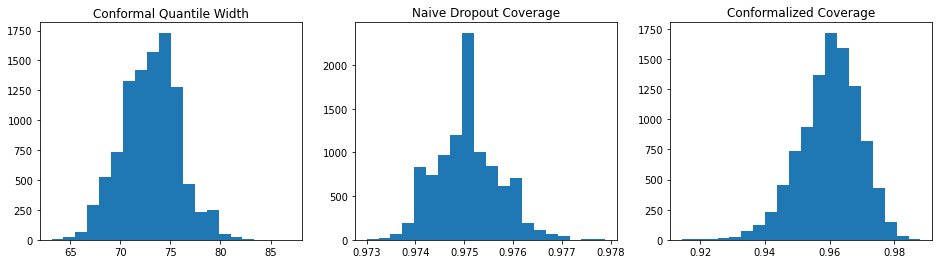

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
np.array(conformal_coverage).mean(), np.array(conformal_coverage).std()

(0.9600830561533947, 0.009199769913845057)

In [ ]:
np.array(quantile_width).mean(), np.array(quantile_width).std()

(73.02637543732592, 2.823158080053921)

In [ ]:
get_quantile_width(regression_quantiles)

79.00061

# alpha = 0.1

In [ ]:
target = np.array(y_list)
regression_quantiles = np.array(pred_list).transpose()

In [ ]:
get_coverage(regression_quantiles, target)

0.9012653715915167

In [ ]:
alpha = 0.1

In [ ]:
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(regression_quantiles,
                            target, alpha,
                            caliberation_size = 500, n_simulation=10000)

Mean qhat: 1.083388917024898


Text(0.5, 1.0, 'Conformalized Coverage')

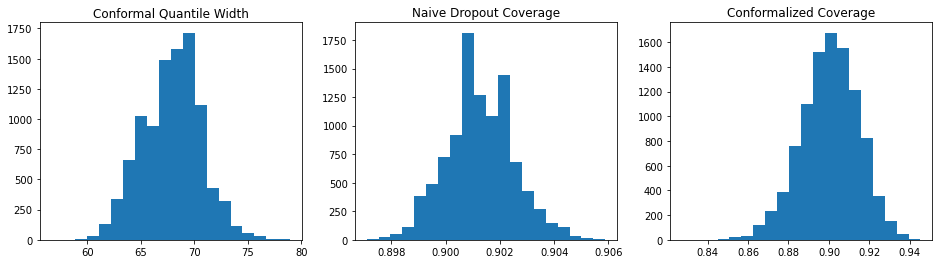

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
np.array(conformal_coverage).mean(), np.array(conformal_coverage).std()

(0.9004579729994131, 0.014062748735872597)

In [ ]:
np.array(quantile_width).mean(), np.array(quantile_width).std()

(67.91108910500198, 2.7168089173243213)

## alpha = 0.2

In [ ]:
target = np.array(y_list)
regression_quantiles = np.array(pred_list).transpose()

In [ ]:
get_coverage(regression_quantiles, target)

0.8732846194974158

In [ ]:
alpha = 0.2

In [ ]:
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(regression_quantiles,
                            target, alpha,
                            caliberation_size = 500, n_simulation=10000)

Mean qhat: 4.558586461282727


Text(0.5, 1.0, 'Conformalized Coverage')

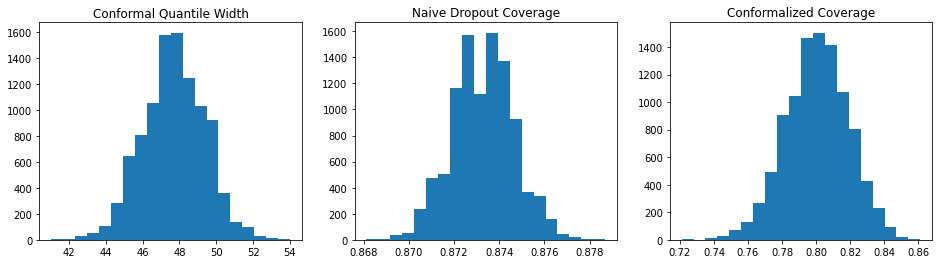

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
np.array(conformal_coverage).mean(), np.array(conformal_coverage).std()

(0.8005480923498337, 0.01848865298118122)

In [ ]:
np.array(quantile_width).mean(), np.array(quantile_width).std()

(47.71362034777169, 1.6720386487836922)

## alpha = 0.4

In [ ]:
alpha = 0.4
target = np.array(y_list)
regression_quantiles = np.array(pred_list).transpose()
get_coverage(regression_quantiles, target)

0.6177152022812333

In [ ]:
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(regression_quantiles,
                            target, alpha,
                            caliberation_size = 500, n_simulation=10000)

Mean qhat: 0.6080491787424098


Text(0.5, 1.0, 'Conformalized Coverage')

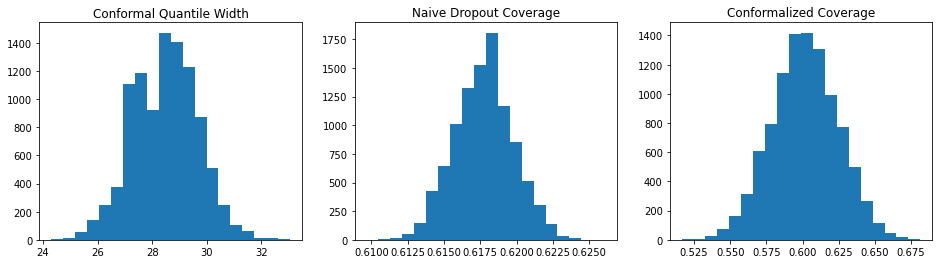

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
np.array(conformal_coverage).mean(), np.array(conformal_coverage).std()

(0.6017429270201526, 0.022858967311567967)

In [ ]:
np.array(quantile_width).mean(), np.array(quantile_width).std()

(28.489124839701173, 1.1879513170089708)

#Dropout Quantiles

In [ ]:
def build_quantile(array, quantile_value):
  array = np.sort(array, axis = 0)
  length = array.shape[0]
  indices = (round(quantile_value[0]*length)-1, round(quantile_value[1]*length)-1)
  
  return array[indices, :]

##Dropout = 0.4

In [ ]:
alpha = 0.04

In [ ]:
with open('dropout_40_200.pkl', 'rb') as f:
   final_dict = pickle.load(f)

Mean qhat: 23.609414973718266


Text(0.5, 1.0, 'Conformalized Coverage')

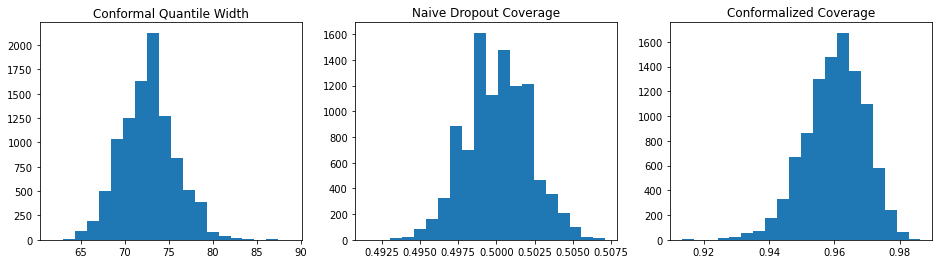

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
print(np.array(quantile_width).mean(), np.array(quantile_width).std())
print(np.array(naive_coverage).mean(), np.array(naive_coverage).std())
print(np.array(conformal_coverage).mean(), np.array(conformal_coverage).std())

72.63542668039743 3.1218467917807433
0.500113402465271 0.0020959951167884216
0.9600364507924085 0.009166262723763195


In [ ]:
alpha = 0.1

Mean qhat: 18.869644246002963


Text(0.5, 1.0, 'Conformalized Coverage')

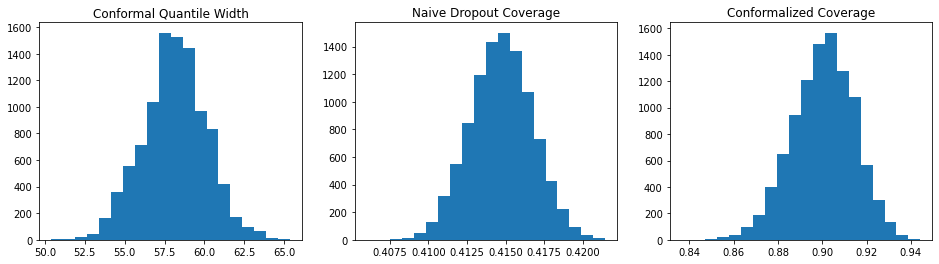

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
print(np.array(quantile_width).mean(), np.array(quantile_width).std())
print(np.array(naive_coverage).mean(), np.array(naive_coverage).std())
print(np.array(conformal_coverage).mean(), np.array(conformal_coverage).std())

58.141345518772376 1.9846766356641565
0.4147255527294072 0.0020532504555099912
0.9003860301310899 0.013945966142961721


In [ ]:
alpha = 0.2

Mean qhat: 14.754562566251375


Text(0.5, 1.0, 'Conformalized Coverage')

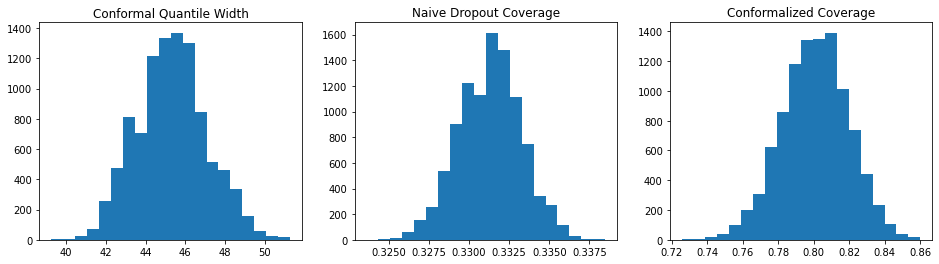

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
print(np.array(quantile_width).mean(), np.array(quantile_width).std())
print(np.array(naive_coverage).mean(), np.array(naive_coverage).std())
print(np.array(conformal_coverage).mean(), np.array(conformal_coverage).std())

45.327240708925096 1.774138610587431
0.3312977890823714 0.001947075710563326
0.8007623557033848 0.018839131461029005


In [ ]:
alpha = 0.4

Mean qhat: 9.827765633727262


Text(0.5, 1.0, 'Conformalized Coverage')

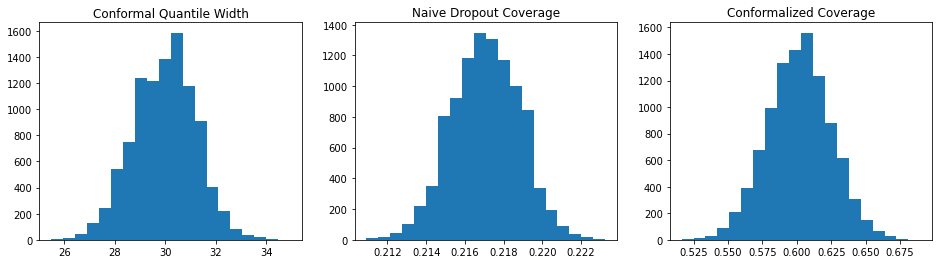

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
print(np.array(quantile_width).mean(), np.array(quantile_width).std())
print(np.array(naive_coverage).mean(), np.array(naive_coverage).std())
print(np.array(conformal_coverage).mean(), np.array(conformal_coverage).std())

29.970889404007018 1.2318685997289165
0.21706609274114652 0.0017340739513532486
0.6018096654275092 0.022927817307088684


##Dropout = .35

In [ ]:
alpha = 0.04

In [ ]:
with open('dropout_35_200.pkl', 'rb') as f:
   final_dict = pickle.load(f)

Mean qhat: 23.724085709251412


Text(0.5, 1.0, 'Conformalized Coverage')

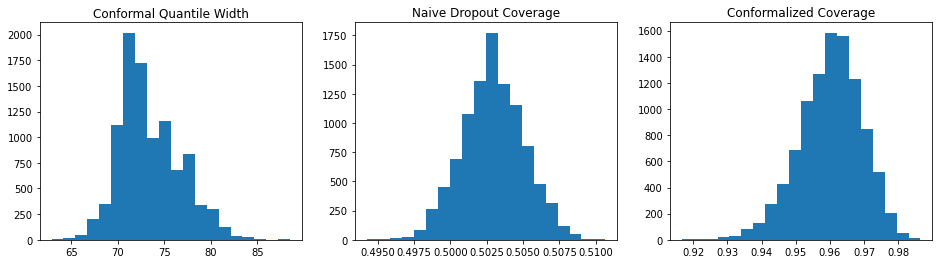

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
print(np.array(quantile_width).mean(), np.array(quantile_width).std())
print(np.array(naive_coverage).mean(), np.array(naive_coverage).std())
print(np.array(conformal_coverage).mean(), np.array(conformal_coverage).std())

73.37621440405222 3.2862849849064077
0.5029407552338094 0.002114013942621137
0.9601385443161807 0.009159537362770217


In [ ]:
alpha = 0.1

Mean qhat: 18.773910372880177


Text(0.5, 1.0, 'Conformalized Coverage')

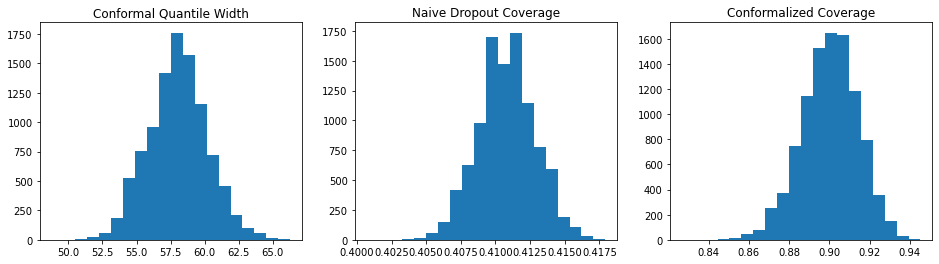

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
print(np.array(quantile_width).mean(), np.array(quantile_width).std())
print(np.array(naive_coverage).mean(), np.array(naive_coverage).std())
print(np.array(conformal_coverage).mean(), np.array(conformal_coverage).std())

58.04924049927335 2.1560634390345865
0.41076744277049504 0.002058404466329847
0.9001027196243399 0.01402434149993745


In [ ]:
alpha = 0.2

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']

In [ ]:
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)

Mean qhat: 14.486422599219898


Text(0.5, 1.0, 'Conformalized Coverage')

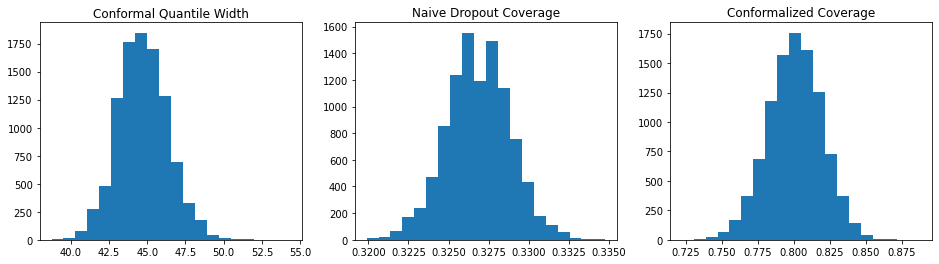

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
np.array(quantile_width).mean(), np.array(quantile_width).std()

(44.75137823222364, 1.6211342899147059)

In [ ]:
np.array(naive_coverage).mean(), np.array(naive_coverage).std()

(0.326834592056349, 0.0019731041985841394)

In [ ]:
np.array(conformal_coverage).mean(), np.array(conformal_coverage).std()

(0.800840931324594, 0.018804217674767212)

In [ ]:
get_quantile_width(dropout_quantiles)

15.77878

In [ ]:
alpha = 0.4

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)

Mean qhat: 9.743139138709257


Text(0.5, 1.0, 'Conformalized Coverage')

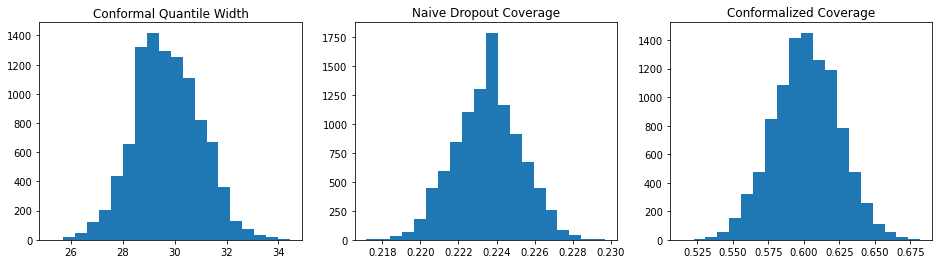

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
print(np.array(quantile_width).mean(), np.array(quantile_width).std())
print(np.array(naive_coverage).mean(), np.array(naive_coverage).std())
print(np.array(conformal_coverage).mean(), np.array(conformal_coverage).std())

29.714756664222605 1.273532760035929
0.22350647622774406 0.001725657627574292
0.6015405987086676 0.02292725384714449


##Dropout = .30

In [ ]:
alpha = 0.04

In [ ]:
with open('dropout_30_200.pkl', 'rb') as f:
   final_dict = pickle.load(f)

Mean qhat: 23.288583521329887


Text(0.5, 1.0, 'Conformalized Coverage')

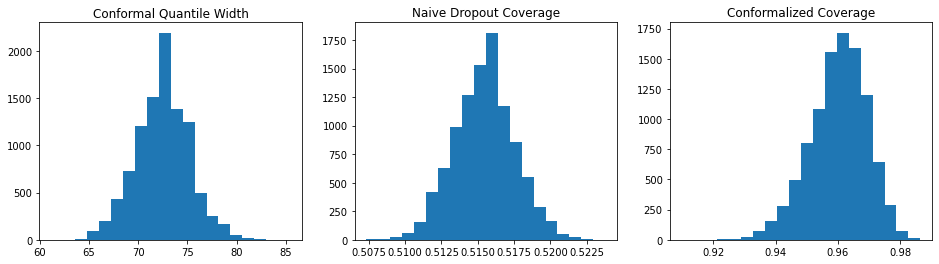

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
print(np.array(quantile_width).mean(), np.array(quantile_width).std())
print(np.array(naive_coverage).mean(), np.array(naive_coverage).std())
print(np.array(conformal_coverage).mean(), np.array(conformal_coverage).std())

72.46055342987458 2.711195155302533
0.5154291723733125 0.0020759688881687786
0.9601155742516143 0.009133974639376043


In [ ]:
alpha = 0.1

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']

In [ ]:
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)

Mean qhat: 18.727071650955967


Text(0.5, 1.0, 'Conformalized Coverage')

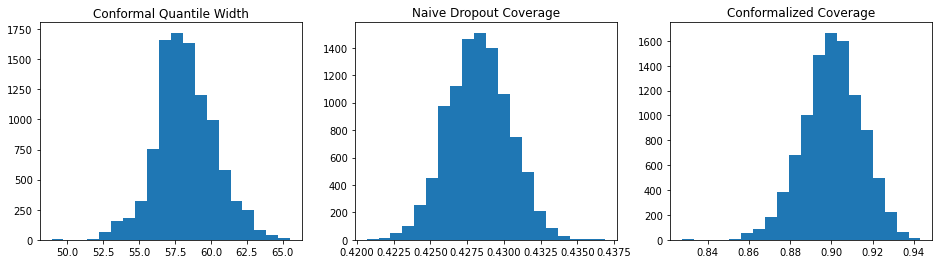

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
np.array(quantile_width).mean(), np.array(quantile_width).std()

(58.22603000095879, 2.0720100046434275)

In [ ]:
np.array(conformal_coverage).mean(), np.array(conformal_coverage).std()

(0.900524320093915, 0.014085918966700856)

In [ ]:
np.array(naive_coverage).mean(), np.array(naive_coverage).std()

(0.42828266484054, 0.002068252828864765)

In [ ]:
get_quantile_width(dropout_quantiles)

20.772179

In [ ]:
alpha = 0.2

Mean qhat: 14.420991976245883


Text(0.5, 1.0, 'Conformalized Coverage')

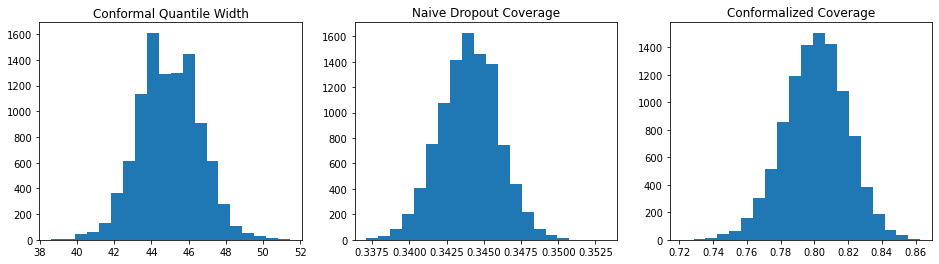

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (alpha/2, 1-alpha/2))
target_dropout = final_dict['age']
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
np.array(quantile_width).mean(), np.array(quantile_width).std()

(44.95098422152694, 1.6367053264586)

In [ ]:
np.array(naive_coverage).mean(), np.array(naive_coverage).std()

(0.34397249070631974, 0.0019829478851826027)

##Dropout = .25

In [ ]:
with open('dropout_25_175.pkl', 'rb') as f:
   final_dict = pickle.load(f)

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (0.1, 0.9))
target_dropout = final_dict['age']

In [ ]:
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)

Mean qhat: 20.312437458258056


Text(0.5, 1.0, 'Conformalized Coverage')

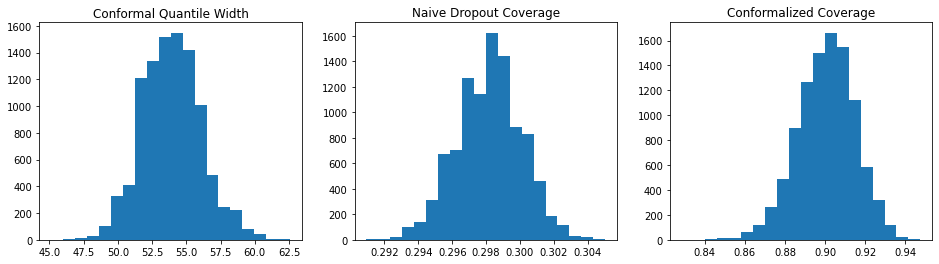

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
np.array(quantile_width).mean(), np.array(quantile_width).std()

(53.93247322919078, 2.155607653219078)

In [ ]:
get_quantile_width(dropout_quantiles)

13.307734

##Dropout = 0.20

In [ ]:
with open('dropout_20_200.pkl', 'rb') as f:
   final_dict = pickle.load(f)

In [ ]:
dropout_quantiles = build_quantile(final_dict["pred"], (0.1, 0.9))
target_dropout = final_dict['age']

In [ ]:
quantile_width, conformal_coverage, naive_coverage = generate_conformal_sets(dropout_quantiles,
                                              target_dropout, alpha,
                                              caliberation_size = 500, n_simulation=10000)

Mean qhat: 20.201156352632523


Text(0.5, 1.0, 'Conformalized Coverage')

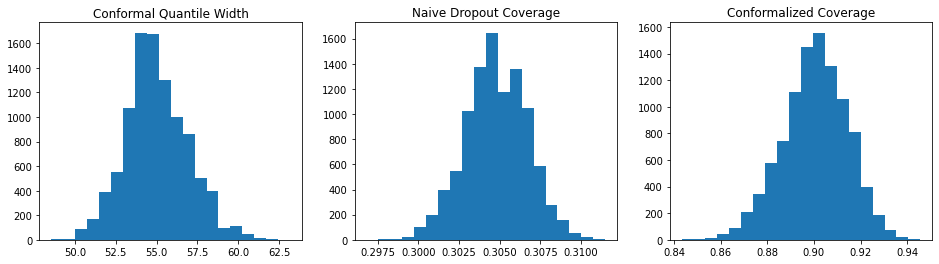

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(16,4))
axis[0].hist(quantile_width, bins = 20)
axis[0].set_title("Conformal Quantile Width")
  
axis[1].hist(naive_coverage, bins = 20)
axis[1].set_title("Naive Dropout Coverage")
  
axis[2].hist(conformal_coverage, bins = 20)
axis[2].set_title("Conformalized Coverage")


In [ ]:
get_quantile_width(dropout_quantiles)

14.612447

In [ ]:
np.array(quantile_width).mean(), np.array(quantile_width).std(), 

(55.014432864819085, 1.91793824466217)

In [ ]:
mean = 0.
std = 0.
for batch in tqdm(train_dataloader):
    image = batch['image'].to(device)
    age = batch['age'].to(device)
    batch_samples = image.size(0) # batch size (the last batch can have smaller size!)
    image = image.view(batch_samples, image.size(1), -1)
    mean += image.mean(2).sum(0)
    std += image.std(2).sum(0)

mean /= len(train_dataloader.dataset)
std /= len(train_dataloader.dataset)

  0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
mean, std

(tensor([0.1871, 0.1871, 0.1871], device='cuda:0'),
 tensor([0.1401, 0.1401, 0.1401], device='cuda:0'))

In [ ]:
final_dict["pred"][:, 0]

array([ 97.58034 , 101.0818  ,  93.187035,  99.55512 ,  93.74219 ,
       101.25834 ,  92.04772 ,  96.61313 , 102.61315 ,  92.42794 ,
       100.063   , 109.754234,  89.81794 , 100.03874 ,  98.499245,
        96.844925, 101.569016,  94.66562 ,  90.17781 ,  85.631325,
        92.37956 , 100.6544  ,  84.60481 , 102.204475, 100.3393  ,
        99.1386  , 107.277534,  97.173225,  94.11133 , 104.45913 ,
        98.7822  ,  94.83999 ,  92.958916, 100.056145,  96.29003 ,
        97.97761 ,  91.93252 ,  95.04923 ,  96.34482 ,  91.59593 ,
        93.83112 ,  90.476265,  87.26156 ,  99.482025,  94.65623 ,
       103.93479 , 101.972244,  99.18446 , 105.50509 , 100.05742 ,
        95.04102 ,  82.48668 ,  92.77518 , 107.40227 ,  98.62871 ,
       102.43215 ,  82.92324 ,  97.684074,  97.99059 ,  96.36523 ,
        88.74914 ,  95.8146  , 110.58318 , 102.16593 ,  96.31745 ,
       102.91093 ,  83.19771 ,  96.73466 , 106.175865, 103.609474,
       100.738144,  97.294   ,  99.8504  ,  95.938484, 101.368